# Time Series Preprocessing Pipeline for Flight Delay Data

This notebook builds upon the base preprocessing pipeline to create features specifically optimized for time series models such as ARIMA, Prophet, and other forecasting algorithms. Time series analysis requires specific preprocessing steps including proper temporal aggregation, handling of seasonality, and preparation of lagged features.

## Key Processing Steps:
1. Loading the base preprocessed data
2. Temporal aggregation (daily, hourly)
3. Time series feature engineering (lags, rolling windows)
4. Handling seasonality
5. Stationarity testing and transformations
6. Creation of exogenous variables
7. Time-based train-test splits with forecast horizon
8. Exporting the processed data for time series model training

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import pickle

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
BASE_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'base_preprocessed_flights.csv')
TS_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ts_ready_flights')
TS_MODEL_PATH = path.join(project_root, 'models', 'ts')

# Create directories if they don't exist
os.makedirs(os.path.dirname(TS_PROCESSED_PATH), exist_ok=True)
os.makedirs(TS_MODEL_PATH, exist_ok=True)

print(f"Base processed data path: {BASE_PROCESSED_PATH}")
print(f"Time Series processed data path: {TS_PROCESSED_PATH}")
print(f"Time Series model path: {TS_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Base processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv
Time Series processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights
Time Series model path: c:\xampp\htdocs\Forecasting_Flights-DataScience\models\ts
Libraries and paths configured.


In [2]:
# Function to handle negative delays in any dataframe
def fix_negative_delays(df):
    """Set any negative delay values to zero"""
    delay_columns = ['DEP_DELAY', 'ARR_DELAY', 'avg_delay', 'median_delay', 'max_delay', 'min_delay']
    for col in delay_columns:
        if col in df.columns:
            df[col] = df[col].clip(lower=0)
    return df



In [3]:
# Function to load data in chunks
def load_processed_data(file_path, chunk_size=500000):
    """
    Generator function to load preprocessed data in chunks
    """
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        # Fix any negative delays in the chunk
        chunk = fix_negative_delays(chunk)
        
        yield chunk

In [4]:
# Inspect the data
first_chunk = next(load_processed_data(BASE_PROCESSED_PATH))

print(f"Data shape of first chunk: {first_chunk.shape}")
print("\nColumns and data types:")
for col in first_chunk.columns:
    print(f"- {col}: {first_chunk[col].dtype}")

print("\nSample data (first 5 rows):")
display(first_chunk.head())

Data shape of first chunk: (500000, 41)

Columns and data types:
- FL_DATE: datetime64[ns]
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: float64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_WEATHER: float64
- DELAY_DUE_NAS: float64
- DELAY_DUE_SECURITY: float64
- DELAY_DUE_LATE_AIRCRAFT: float64
- YEAR: int64
- QUARTER: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample data (first 5 rows):


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",715,711,0.0,19.0,1210.0,1443.0,4.0,901,1447.0,0.0,0,NaN,0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,2019,1,1,9,2,1,0,11,Morning
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",1280,1274,0.0,9.0,2123.0,2232.0,38.0,1395,2310.0,0.0,0,NaN,0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,2022,4,11,19,5,4,1,21,Evening
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,2022,3,7,22,4,3,0,9,Morning
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",969,968,0.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,2023,1,3,6,0,2,0,16,Afternoon
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0,2019,3,7,31,2,3,0,10,Morning


In [5]:
# --- MISSING VALUE HANDLING FOR TS PIPELINE ---
def drop_columns_with_high_missing(df, threshold=0.5):
    """
    Drop columns with >= threshold proportion of missing values.
    """
    missing_ratio = df.isnull().mean(axis=0)
    cols_to_drop = missing_ratio[missing_ratio >= threshold].index.tolist()
    if cols_to_drop:
        print(f"Dropping columns with >= {int(threshold*100)}% missing values: {cols_to_drop}")
    return df.drop(columns=cols_to_drop)



In [6]:
# Check missing values in each column after dropping columns with high missingness
df_after_drop = drop_columns_with_high_missing(first_chunk, threshold=0.5)
missing_counts = df_after_drop.isnull().sum()
missing_percent = df_after_drop.isnull().mean() * 100

print("Missing values per column (after dropping high-missing columns):")
for col in df_after_drop.columns:
    print(f"- {col}: {missing_counts[col]} missing ({missing_percent[col]:.2f}%)")

Dropping columns with >= 50% missing values: ['CANCELLATION_CODE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
Missing values per column (after dropping high-missing columns):
- FL_DATE: 0 missing (0.00%)
- AIRLINE: 0 missing (0.00%)
- AIRLINE_DOT: 0 missing (0.00%)
- AIRLINE_CODE: 0 missing (0.00%)
- DOT_CODE: 0 missing (0.00%)
- FL_NUMBER: 0 missing (0.00%)
- ORIGIN: 0 missing (0.00%)
- ORIGIN_CITY: 0 missing (0.00%)
- DEST: 0 missing (0.00%)
- DEST_CITY: 0 missing (0.00%)
- CRS_DEP_TIME: 0 missing (0.00%)
- DEP_TIME: 0 missing (0.00%)
- DEP_DELAY: 0 missing (0.00%)
- TAXI_OUT: 0 missing (0.00%)
- WHEELS_OFF: 0 missing (0.00%)
- WHEELS_ON: 134 missing (0.03%)
- TAXI_IN: 134 missing (0.03%)
- CRS_ARR_TIME: 0 missing (0.00%)
- ARR_TIME: 134 missing (0.03%)
- ARR_DELAY: 1240 missing (0.25%)
- CANCELLED: 0 missing (0.00%)
- DIVERTED: 0 missing (0.00%)
- CRS_ELAPSED_TIME: 0 missing (0.00%)
- ELAPSED_TIME: 1240 missing (0.25%)

In [7]:
# Impute ARR_DELAY with DEP_DELAY where possible
if 'ARR_DELAY' in df_after_drop.columns and 'DEP_DELAY' in df_after_drop.columns:
    mask = df_after_drop['ARR_DELAY'].isna() & df_after_drop['DEP_DELAY'].notna()
    df_after_drop.loc[mask, 'ARR_DELAY'] = df_after_drop.loc[mask, 'DEP_DELAY']

# Impute numeric columns with median
numeric_cols = df_after_drop.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df_after_drop[col].fillna(df_after_drop[col].median(), inplace=True)

# Impute categorical columns with mode
categorical_cols = df_after_drop.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if df_after_drop[col].isnull().any():
        df_after_drop[col].fillna(df_after_drop[col].mode()[0], inplace=True)

# Store the imputed result in a new DataFrame
df_imputed = df_after_drop.copy()

# Optionally print a summary to verify the changes
print("Missing values after imputation:")
missing_counts = df_imputed.isnull().sum()
missing_percent = df_imputed.isnull().mean() * 100
for col in df_imputed.columns:
    print(f"- {col}: {missing_counts[col]} missing ({missing_percent[col]:.2f}%)")


Missing values after imputation:
- FL_DATE: 0 missing (0.00%)
- AIRLINE: 0 missing (0.00%)
- AIRLINE_DOT: 0 missing (0.00%)
- AIRLINE_CODE: 0 missing (0.00%)
- DOT_CODE: 0 missing (0.00%)
- FL_NUMBER: 0 missing (0.00%)
- ORIGIN: 0 missing (0.00%)
- ORIGIN_CITY: 0 missing (0.00%)
- DEST: 0 missing (0.00%)
- DEST_CITY: 0 missing (0.00%)
- CRS_DEP_TIME: 0 missing (0.00%)
- DEP_TIME: 0 missing (0.00%)
- DEP_DELAY: 0 missing (0.00%)
- TAXI_OUT: 0 missing (0.00%)
- WHEELS_OFF: 0 missing (0.00%)
- WHEELS_ON: 0 missing (0.00%)
- TAXI_IN: 0 missing (0.00%)
- CRS_ARR_TIME: 0 missing (0.00%)
- ARR_TIME: 0 missing (0.00%)
- ARR_DELAY: 0 missing (0.00%)
- CANCELLED: 0 missing (0.00%)
- DIVERTED: 0 missing (0.00%)
- CRS_ELAPSED_TIME: 0 missing (0.00%)
- ELAPSED_TIME: 0 missing (0.00%)
- AIR_TIME: 0 missing (0.00%)
- DISTANCE: 0 missing (0.00%)
- YEAR: 0 missing (0.00%)
- QUARTER: 0 missing (0.00%)
- MONTH: 0 missing (0.00%)
- DAY_OF_MONTH: 0 missing (0.00%)
- DAY_OF_WEEK: 0 missing (0.00%)
- SEASON:

## Time Series Pre-analysis



In [8]:
# Modify the aggregate_to_time_series function to handle non-chunked data
def aggregate_to_time_series(df, agg_level='daily', target_col='DEP_DELAY'):
    """
    Aggregate flight data into time series at different temporal resolutions
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    agg_level : str
        Level of aggregation ('daily', 'hourly', 'airport_daily', 'carrier_daily')
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data
    """
    # Fix any negative delays before aggregation
    df = fix_negative_delays(df)
    
    # Ensure we have date information
    if 'FL_DATE' not in df.columns:
        print("Error: FL_DATE column not found")
        return None
    
    # Define groupby columns based on aggregation level
    if agg_level == 'daily':
        groupby_cols = ['FL_DATE']
    elif agg_level == 'hourly':
        if 'DEP_HOUR' in df.columns:
            df['DATETIME'] = df['FL_DATE'] + pd.to_timedelta(df['DEP_HOUR'], unit='h')
            groupby_cols = ['DATETIME']
        else:
            print("Error: DEP_HOUR column not found for hourly aggregation")
            return None
    elif agg_level == 'airport_daily':
        if 'ORIGIN' in df.columns:
            groupby_cols = ['FL_DATE', 'ORIGIN']
        else:
            print("Error: ORIGIN column not found for airport_daily aggregation")
            return None
    elif agg_level == 'carrier_daily':
        if 'OP_CARRIER' in df.columns:
            groupby_cols = ['FL_DATE', 'OP_CARRIER']
        else:
            print("Error: OP_CARRIER column not found for carrier_daily aggregation")
            return None
    else:
        print(f"Error: Unknown aggregation level: {agg_level}")
        return None
    
    # Skip chunk if target column is not present
    if target_col not in df.columns:
        print(f"Error: {target_col} column not found in the DataFrame")
        return None
    
    # Aggregate data
    agg = df.groupby(groupby_cols).agg(
        avg_delay=(target_col, 'mean'),
        median_delay=(target_col, 'median'),
        max_delay=(target_col, 'max'),
        min_delay=(target_col, 'min'),
        std_delay=(target_col, 'std'),
        num_flights=(target_col, 'count')
    )
    
    # Fix negative delays in aggregated data
    agg = fix_negative_delays(agg)
    
    # Sort by date and fix any remaining negative delays
    agg = agg.sort_index()
    agg = fix_negative_delays(agg)
    
    return agg




################# ts_daily #####################

Daily time series shape: (1338, 6)

First few rows:


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights
FL_DATE,,,,,,
2019-01-01,13.567647,0.0,198.0,0.0,29.342221,340
2019-01-02,16.594406,0.0,386.0,0.0,41.435837,429
2019-01-03,13.640732,0.0,745.0,0.0,47.075057,437
2019-01-04,9.534442,0.0,668.0,0.0,41.242799,421
2019-01-05,11.402089,0.0,667.0,0.0,43.920981,383


Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00
Total days: 1338


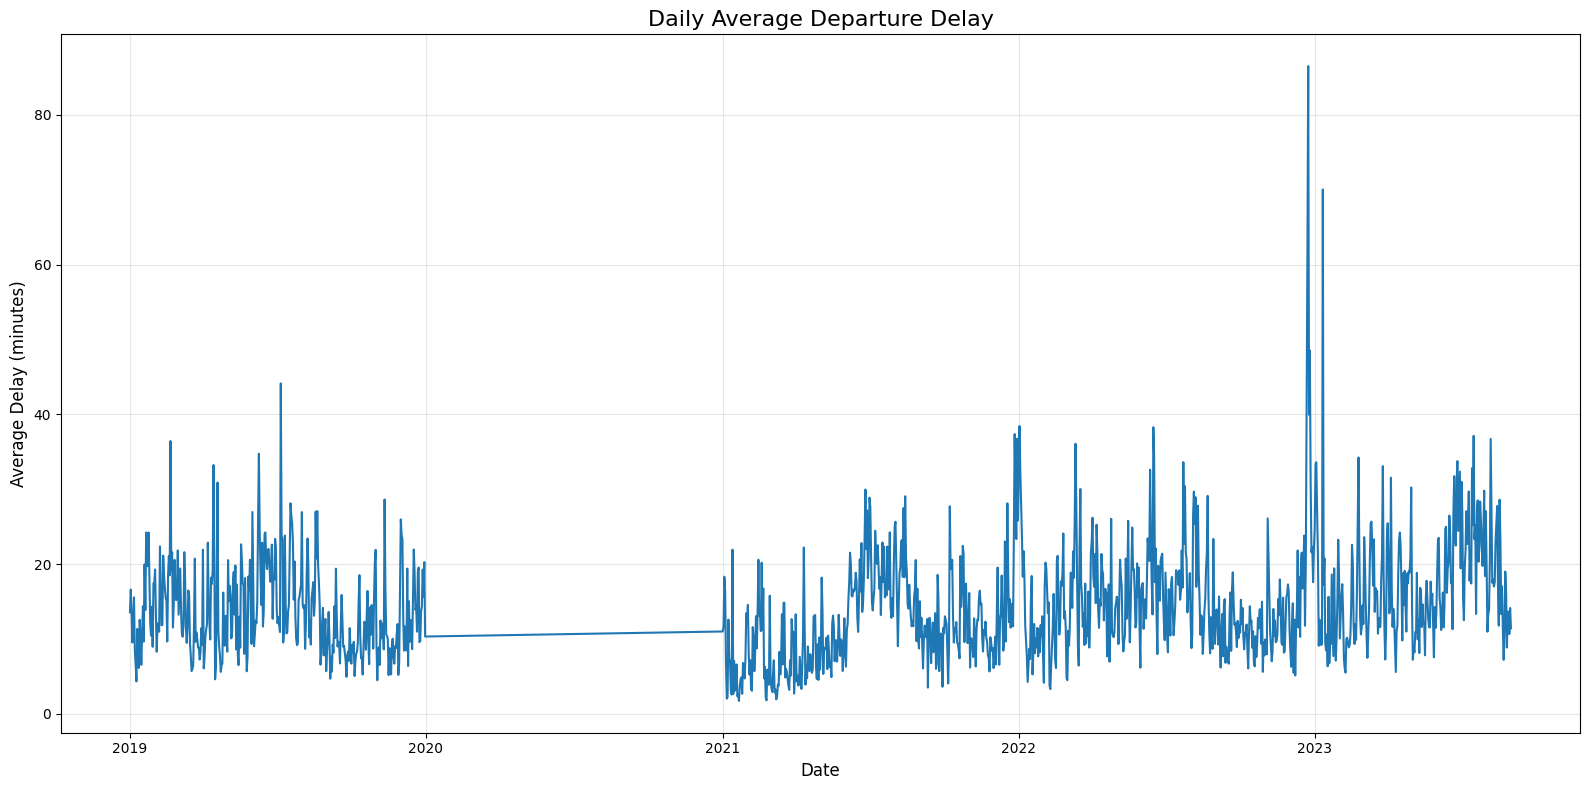

In [9]:
# Use df_imputed instead of processed data for aggregation
ts_daily = aggregate_to_time_series(df_imputed, agg_level='daily')

# Display the shape of the aggregated time series
print(f"Daily time series shape: {ts_daily.shape}")
print("\nFirst few rows:")
display(ts_daily.head())

# Check the date range of the aggregated time series
print(f"Date range: {ts_daily.index.min()} to {ts_daily.index.max()}")
print(f"Total days: {len(ts_daily)}")

# Plot the daily average delay
plt.figure(figsize=(16, 8))
plt.plot(ts_daily.index, ts_daily['avg_delay'], linewidth=1.5)
plt.title('Daily Average Departure Delay', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Check for stationarity
def check_stationarity(ts, column='avg_delay'):
    """
    Check if a time series is stationary using the Augmented Dickey-Fuller test
    """
    # Calculate rolling statistics
    rolling_mean = ts[column].rolling(window=7).mean()
    rolling_std = ts[column].rolling(window=7).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.plot(ts.index, ts[column], label='Original')
    plt.plot(ts.index, rolling_mean, label='Rolling Mean (7-day)')
    plt.plot(ts.index, rolling_std, label='Rolling Std (7-day)')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Perform ADF test
    result = adfuller(ts[column].dropna())
    
    plt.subplot(212)
    plt.bar(['ADF Statistic', 'p-value', '1%', '5%', '10%'], 
            [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']], 
            color=['blue', 'red', 'green', 'green', 'green'])
    plt.axhline(y=result[4]['5%'], color='green', linestyle='-', alpha=0.5)
    plt.title('Augmented Dickey-Fuller Test Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print test results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("\nConclusion: Time series is stationary (reject null hypothesis)")
        return True
    else:
        print("\nConclusion: Time series is non-stationary (fail to reject null hypothesis)")
        return False

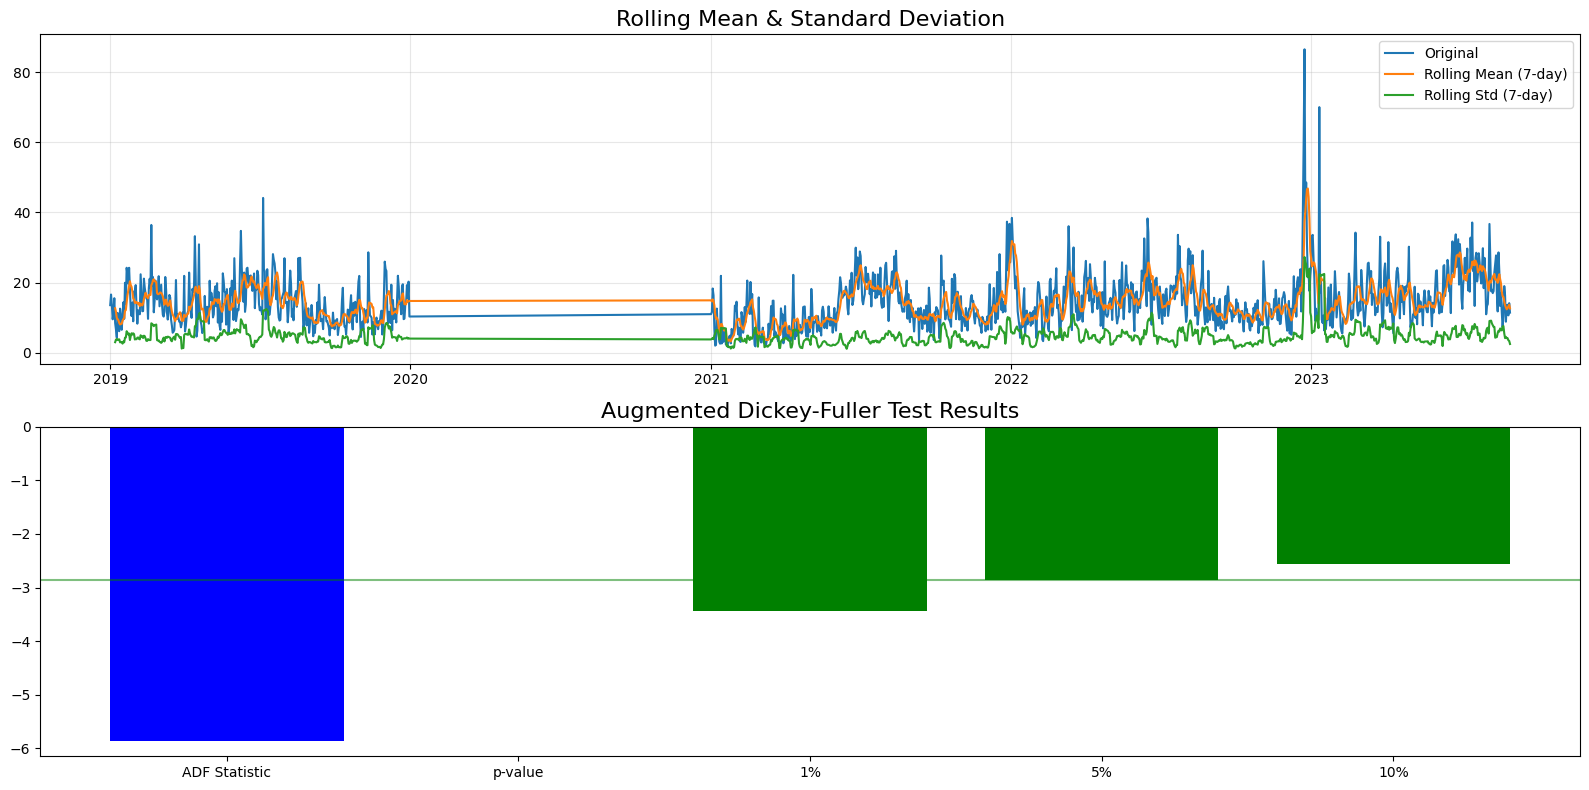

Augmented Dickey-Fuller Test Results:
ADF Statistic: -5.8577
p-value: 0.0000
Critical Values:
   1%: -3.4353
   5%: -2.8637
   10%: -2.5679

Conclusion: Time series is stationary (reject null hypothesis)


In [11]:
# Check stationarity of the daily average delay time series
is_stationary = check_stationarity(ts_daily)

# If not stationary, demonstrate differencing
if not is_stationary:
    # First-order differencing
    ts_daily['diff1'] = ts_daily['avg_delay'].diff().dropna()
    
    # Check stationarity of differenced series
    print("\nChecking stationarity after first-order differencing:")
    is_stationary_diff1 = check_stationarity(ts_daily.dropna(), column='diff1')

In [12]:
# Seasonal decomposition
def decompose_time_series(ts, column='avg_delay'):
    """
    Decompose time series into trend, seasonal, and residual components
    """
    # Fill any missing values with forward fill
    ts_filled = ts[column].fillna(method='ffill')
    
    # Check if we have enough data for decomposition
    if len(ts_filled) < 14:  # Need at least twice the period for weekly seasonality
        print("Not enough data for decomposition")
        return None
    
    # Perform seasonal decomposition with additive model
    try:
        decomposition = seasonal_decompose(ts_filled, model='additive', period=7)  # Weekly seasonality
        
        # Plot decomposition
        plt.figure(figsize=(16, 12))
        
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title('Observed', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonality (Weekly)', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residuals', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
    except Exception as e:
        print(f"Error during decomposition: {e}")
        return None

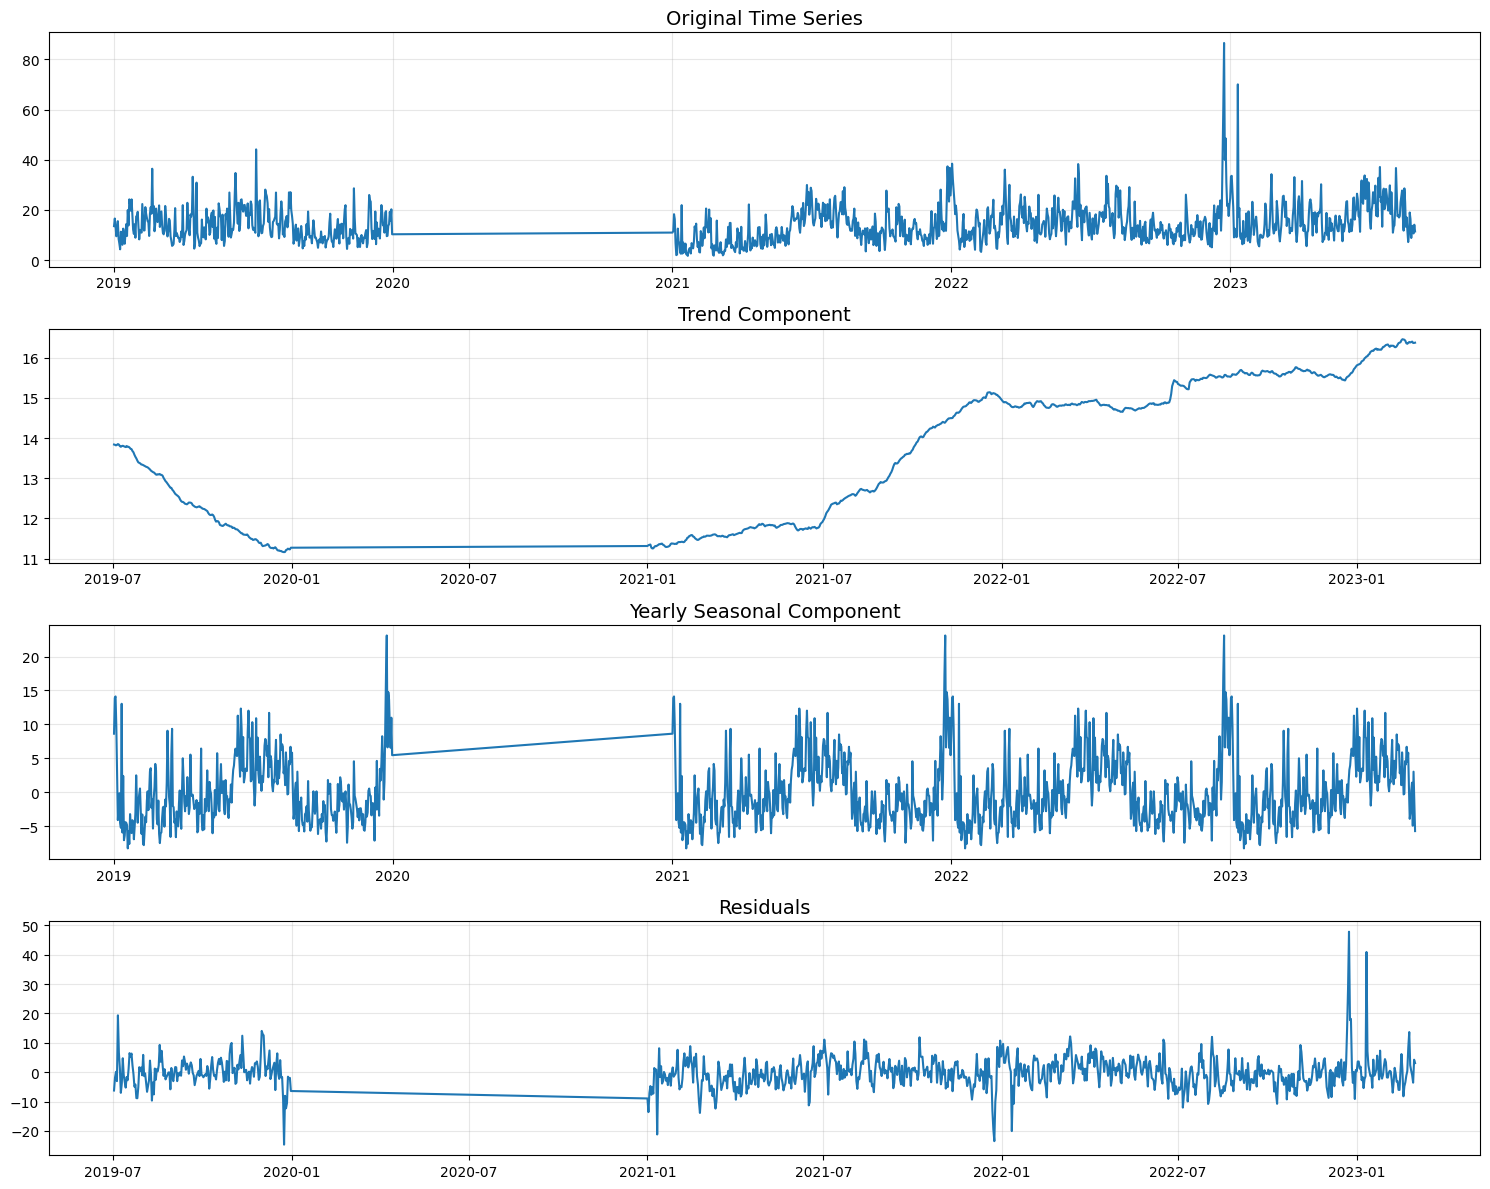

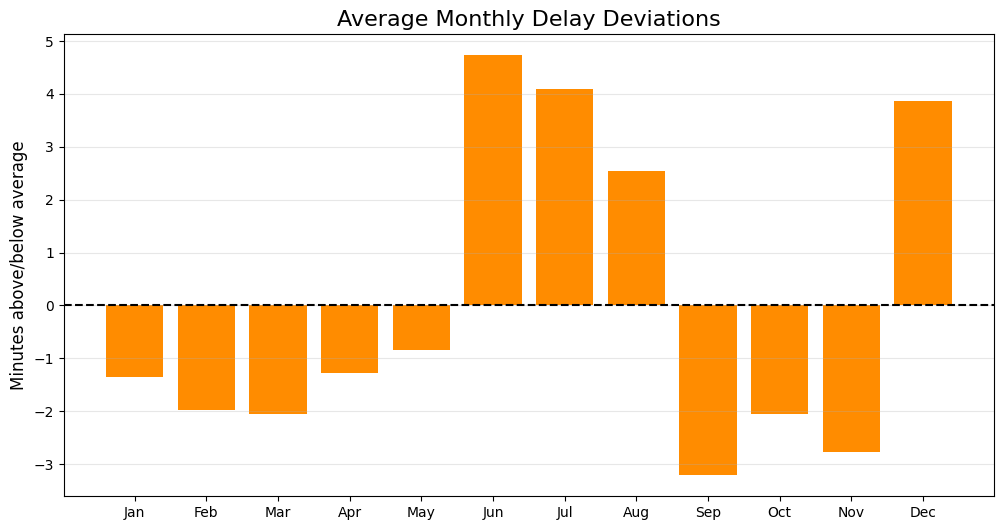


Monthly Delay Deviations from Average:
Jan: -1.35 minutes
Feb: -1.97 minutes
Mar: -2.04 minutes
Apr: -1.28 minutes
May: -0.84 minutes
Jun: +4.73 minutes
Jul: +4.10 minutes
Aug: +2.55 minutes
Sep: -3.21 minutes
Oct: -2.05 minutes
Nov: -2.77 minutes
Dec: +3.87 minutes


In [13]:
# Decompose the time series with yearly seasonality
ts_daily_filled = ts_daily['avg_delay'].fillna(method='ffill').fillna(method='bfill')
decomposition = seasonal_decompose(ts_daily_filled, period=365, model='additive')

# Create a 4x1 grid of subplots showing all components
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# 1. Original Time Series
axes[0].plot(decomposition.observed)
axes[0].set_title('Original Time Series', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 2. Trend Component
axes[1].plot(decomposition.trend)
axes[1].set_title('Trend Component', fontsize=14)
axes[1].grid(True, alpha=0.3)

# 3. Seasonal Component (Yearly)
axes[2].plot(decomposition.seasonal)
axes[2].set_title('Yearly Seasonal Component', fontsize=14)
axes[2].grid(True, alpha=0.3)

# 4. Residual Component
axes[3].plot(decomposition.resid)
axes[3].set_title('Residuals', fontsize=14)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional Visualization: Monthly Averages Bar Plot
plt.figure(figsize=(12, 6))
monthly_avg = pd.Series(decomposition.seasonal).groupby(pd.to_datetime(ts_daily_filled.index).month).mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, monthly_avg, color='darkorange')
plt.title('Average Monthly Delay Deviations', fontsize=16)
plt.ylabel('Minutes above/below average', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print numerical summary
print("\nMonthly Delay Deviations from Average:")
for month, val in zip(months, monthly_avg):
    print(f"{month}: {val:+.2f} minutes")

In [14]:
# Analyze ACF and PACF plots for time series modeling
def analyze_acf_pacf(ts, column='avg_delay', lags=40):
    """
    Analyze auto-correlation and partial auto-correlation functions
    """
    # Fill missing values
    ts_filled = ts[column].fillna(method='ffill')
    
    # Create the plots
    plt.figure(figsize=(16, 8))
    
    plt.subplot(211)
    plot_acf(ts_filled, lags=lags, alpha=0.05, title='Autocorrelation Function (ACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.subplot(212)
    plot_pacf(ts_filled, lags=lags, alpha=0.05, method='ols', title='Partial Autocorrelation Function (PACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

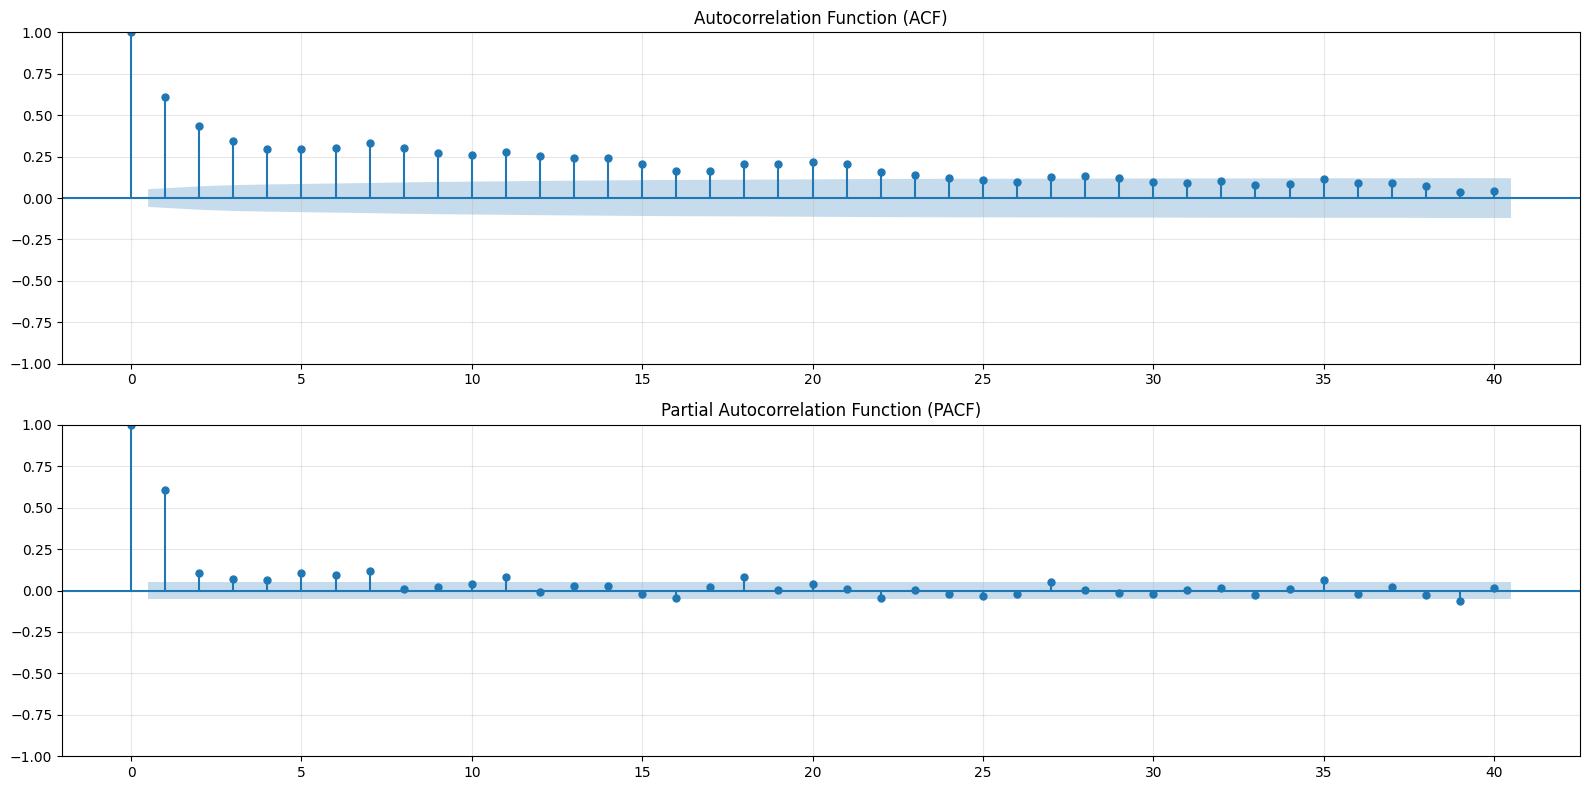

In [15]:
# Analyze ACF and PACF to guide model selection
analyze_acf_pacf(ts_daily)

####################### ts_hourly #########################

Hourly time series shape: (26520, 6)

First few rows:


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights
DATETIME,,,,,,
2019-01-01 02:00:00,6.000000,6.0,6.0,6.0,NaN,1
2019-01-01 05:00:00,18.285714,0.0,119.0,0.0,44.537304,7
2019-01-01 06:00:00,11.360000,0.0,198.0,0.0,39.406937,25
2019-01-01 07:00:00,3.428571,0.0,26.0,0.0,7.242730,21
2019-01-01 08:00:00,6.321429,0.0,81.0,0.0,16.830426,28


Date range: 2019-01-01 02:00:00 to 2023-08-31 23:00:00
Total hours: 26520


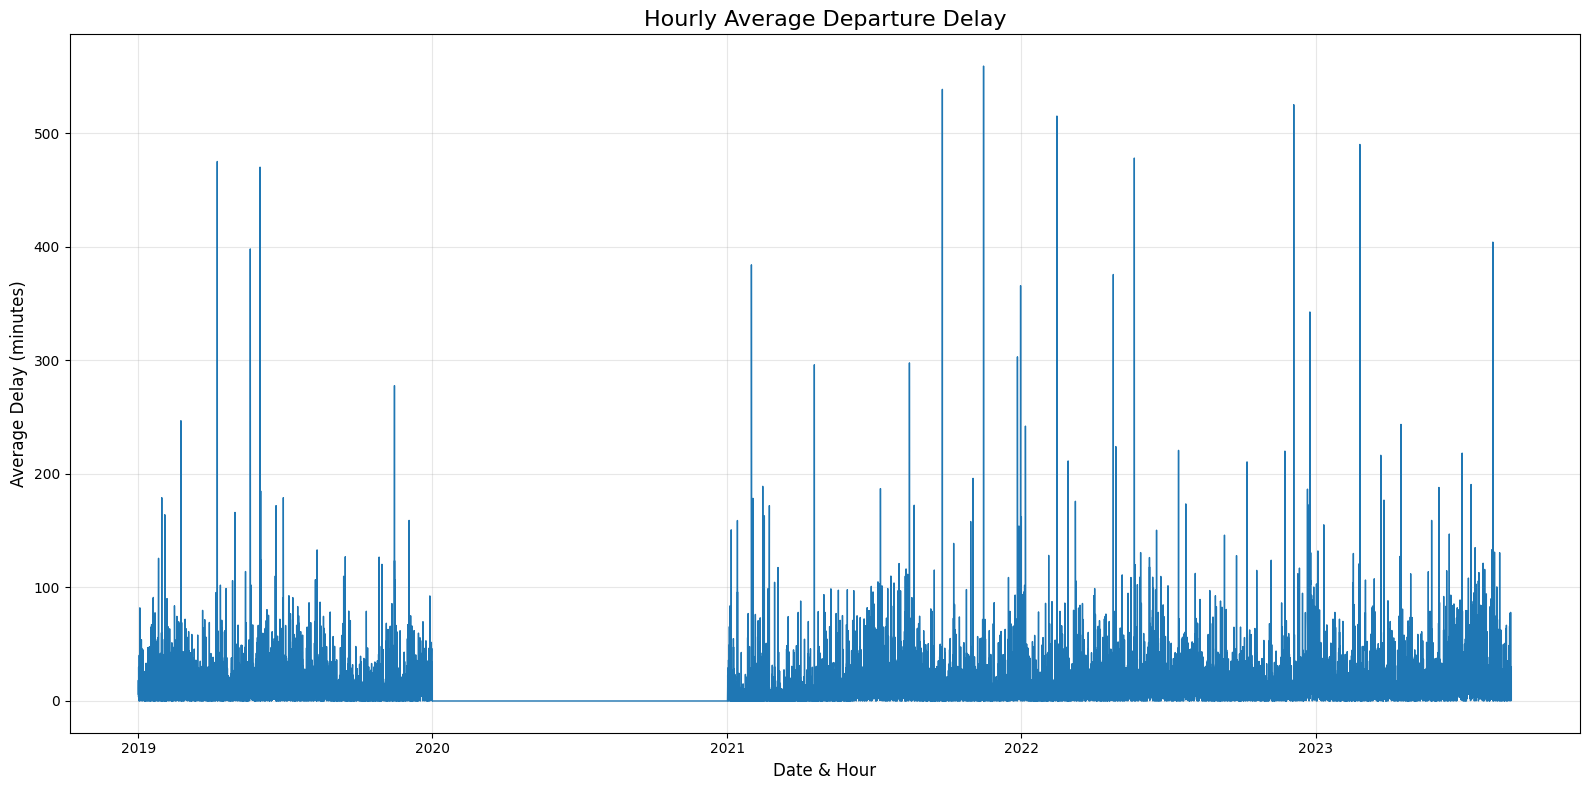

In [16]:
# Create and analyze hourly aggregated time series
ts_hourly = aggregate_to_time_series(df_imputed, agg_level='hourly')

print(f"Hourly time series shape: {ts_hourly.shape}")
print("\nFirst few rows:")
display(ts_hourly.head())  # Shows only first few rows

# Check the date range
print(f"Date range: {ts_hourly.index.min()} to {ts_hourly.index.max()}")
print(f"Total hours: {len(ts_hourly)}")

# Plot the time series
plt.figure(figsize=(16, 8))
plt.plot(ts_hourly.index, ts_hourly['avg_delay'], linewidth=1.0)
plt.title('Hourly Average Departure Delay', fontsize=16)
plt.xlabel('Date & Hour', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


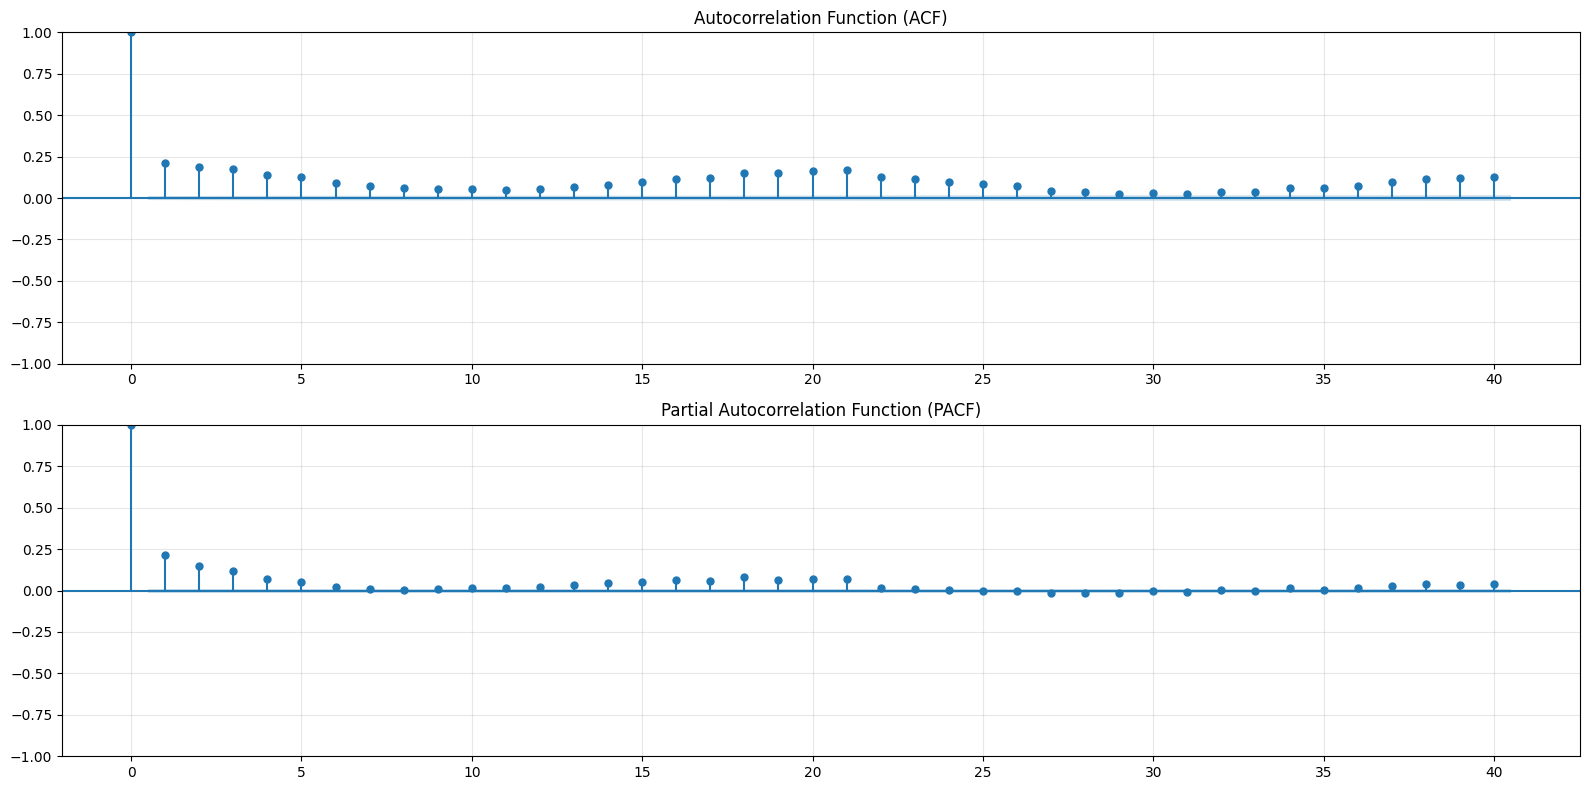

In [17]:
# Analyze ACF and PACF to guide model selection
analyze_acf_pacf(ts_hourly)

In [18]:
def aggregate_airport_daily(df, target_col='DEP_DELAY'):
    """
    Aggregate flight data into daily time series per airport.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data per airport and day
    """
    # Fix any negative delays before aggregation
    df = fix_negative_delays(df)
    
    # Ensure we have date and airport information
    if 'FL_DATE' not in df.columns or 'ORIGIN' not in df.columns:
        print("Error: FL_DATE or ORIGIN column not found")
        return None
    
    # Aggregate data by FL_DATE and ORIGIN (Airport)
    agg = df.groupby(['FL_DATE', 'ORIGIN']).agg(
        avg_delay=(target_col, 'mean'),
        median_delay=(target_col, 'median'),
        max_delay=(target_col, 'max'),
        min_delay=(target_col, 'min'),
        std_delay=(target_col, 'std'),
        num_flights=(target_col, 'count')
    )
    
    # Include other numeric columns (e.g., delays) in the aggregation
    for col in df.select_dtypes(include=['number']).columns:  # Only numeric columns
        if col != target_col:
            agg[f'{col}_mean'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].mean()
            agg[f'{col}_median'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].median()
            agg[f'{col}_max'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].max()
            agg[f'{col}_min'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].min()
            agg[f'{col}_std'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].std()

    # Handle non-numeric columns
    for col in df.select_dtypes(exclude=['number']).columns:  # Non-numeric columns
        if col not in ['FL_DATE', 'ORIGIN']:
            agg[f'{col}_mode'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
            agg[f'{col}_count'] = df.groupby(['FL_DATE', 'ORIGIN'])[col].apply(lambda x: x.count())
    
    # Fix negative delays in aggregated data
    agg = fix_negative_delays(agg)
    
    # Sort by FL_DATE and ORIGIN
    agg = agg.sort_index()
    
    return agg


def aggregate_airport_hourly(df, target_col='DEP_DELAY'):
    """
    Aggregate flight data into hourly time series per airport.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data per airport and hour
    """
    # Fix any negative delays before aggregation
    df = fix_negative_delays(df)
    
    # Ensure we have date, airport, and hour information
    if 'FL_DATE' not in df.columns or 'ORIGIN' not in df.columns or 'DEP_HOUR' not in df.columns:
        print("Error: FL_DATE, ORIGIN, or DEP_HOUR column not found")
        return None
    
    # Add a new datetime column for hourly aggregation
    df['DATETIME'] = df['FL_DATE'] + pd.to_timedelta(df['DEP_HOUR'], unit='h')
    
    # Aggregate data by DATETIME and ORIGIN (Airport)
    agg = df.groupby(['DATETIME', 'ORIGIN']).agg(
        avg_delay=(target_col, 'mean'),
        median_delay=(target_col, 'median'),
        max_delay=(target_col, 'max'),
        min_delay=(target_col, 'min'),
        std_delay=(target_col, 'std'),
        num_flights=(target_col, 'count')
    )
    
    # Include other numeric columns (e.g., delays) in the aggregation
    for col in df.select_dtypes(include=['number']).columns:  # Only numeric columns
        if col != target_col:
            agg[f'{col}_mean'] = df.groupby(['DATETIME', 'ORIGIN'])[col].mean()
            agg[f'{col}_median'] = df.groupby(['DATETIME', 'ORIGIN'])[col].median()
            agg[f'{col}_max'] = df.groupby(['DATETIME', 'ORIGIN'])[col].max()
            agg[f'{col}_min'] = df.groupby(['DATETIME', 'ORIGIN'])[col].min()
            agg[f'{col}_std'] = df.groupby(['DATETIME', 'ORIGIN'])[col].std()

    # Handle non-numeric columns
    for col in df.select_dtypes(exclude=['number']).columns:  # Non-numeric columns
        if col not in ['FL_DATE', 'ORIGIN', 'DEP_HOUR']:
            agg[f'{col}_mode'] = df.groupby(['DATETIME', 'ORIGIN'])[col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
            agg[f'{col}_count'] = df.groupby(['DATETIME', 'ORIGIN'])[col].apply(lambda x: x.count())
    
    # Fix negative delays in aggregated data
    agg = fix_negative_delays(agg)
    
    # Sort by DATETIME and ORIGIN
    agg = agg.sort_index()
    
    return agg


In [19]:
def check_unique_values_in_cat_columns(df):
    """
    Check the number of unique values in each categorical column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    
    Returns:
    --------
    dict
        A dictionary where the keys are the categorical column names and the values are the number of unique values.
    """
    # Select categorical columns (object dtype)
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Create a dictionary to store the count of unique values for each categorical column
    unique_values_dict = {}
    
    for col in cat_columns:
        unique_values_dict[col] = df[col].nunique()  # Count unique values in the column
    
    return unique_values_dict

# Example usage:
unique_values = check_unique_values_in_cat_columns(df_imputed)
print("\nUnique values in each categorical column:")
print(unique_values)



Unique values in each categorical column:
{'AIRLINE': 18, 'AIRLINE_DOT': 18, 'AIRLINE_CODE': 18, 'ORIGIN': 379, 'ORIGIN_CITY': 372, 'DEST': 377, 'DEST_CITY': 370, 'TIME_OF_DAY': 4}


## Feature Engineering for Time Series Models

Based on our analysis, we'll create features specifically designed for time series forecasting. These include:
1. Lag features
2. Rolling statistics
3. Seasonal indicators
4. Holiday indicators
5. External regressors (e.g., weather data, if available)

In [20]:
# Create time series features for forecasting
def create_ts_features(ts_data):
    """
    Create features for time series forecasting
    """
    # Fix any negative delays before feature creation
    ts_data = fix_negative_delays(ts_data)
    
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # ======== LAG FEATURES ========
    # Create lags of the target variable (useful for autoregressive models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, and monthly lags
        ts[f'avg_delay_lag{lag}'] = ts['avg_delay'].shift(lag)
    
    # ======== ROLLING WINDOW FEATURES ========
    # Create rolling statistics
    for window in [3, 7, 14, 28]:
        ts[f'avg_delay_roll_mean{window}'] = ts['avg_delay'].rolling(window=window).mean()
        ts[f'avg_delay_roll_std{window}'] = ts['avg_delay'].rolling(window=window).std()
        ts[f'avg_delay_roll_max{window}'] = ts['avg_delay'].rolling(window=window).max()
        ts[f'avg_delay_roll_min{window}'] = ts['avg_delay'].rolling(window=window).min()
    
    # ======== CALENDAR FEATURES ========
    # Extract date components
    if isinstance(ts.index, pd.DatetimeIndex):
        # Add calendar features
        ts['month'] = ts.index.month
        ts['day_of_week'] = ts.index.dayofweek  # 0=Monday, 6=Sunday
        ts['day_of_year'] = ts.index.dayofyear
        ts['quarter'] = ts.index.quarter
        ts['week_of_year'] = ts.index.isocalendar().week
        
        # Add cyclical encoding of calendar features
        ts['month_sin'] = np.sin(2 * np.pi * ts['month'] / 12)
        ts['month_cos'] = np.cos(2 * np.pi * ts['month'] / 12)
        ts['day_of_week_sin'] = np.sin(2 * np.pi * ts['day_of_week'] / 7)
        ts['day_of_week_cos'] = np.cos(2 * np.pi * ts['day_of_week'] / 7)
        
        # Create weekend indicator
        ts['is_weekend'] = (ts['day_of_week'] >= 5).astype(int)
    
    # ======== TREND FEATURES ========
    # Create a simple trend feature (days since start)
    if isinstance(ts.index, pd.DatetimeIndex):
        ts['trend'] = (ts.index - ts.index.min()).days
    
    # Fix any negative delays that might have been introduced
    ts = fix_negative_delays(ts)
    
    return ts

In [21]:

def add_holiday_indicators(ts_data):
    """
    Add holiday indicators to the time series data using FL_DATE column.
    """
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # Check that FL_DATE is a datetime column
    if not pd.api.types.is_datetime64_any_dtype(ts['FL_DATE']):
        print("Error: FL_DATE is not a datetime column")
        return ts
    
    # Initialize holiday columns
    ts['is_holiday'] = 0
    ts['is_holiday_season'] = 0
    
    # Get years in the data
    years = ts['FL_DATE'].dt.year.unique()
    
    # Define major US holidays (simplified version)
    holidays = []
    for year in years:
        # New Year's Day
        holidays.append(pd.Timestamp(year=year, month=1, day=1))
        
        # Memorial Day (last Monday in May)
        memorial_day = pd.Timestamp(year=year, month=5, day=31)
        memorial_day = memorial_day - pd.Timedelta(days=(memorial_day.dayofweek - 0) % 7)
        holidays.append(memorial_day)
        
        # Independence Day
        holidays.append(pd.Timestamp(year=year, month=7, day=4))
        
        # Labor Day (first Monday in September)
        labor_day = pd.Timestamp(year=year, month=9, day=1)
        labor_day = labor_day + pd.Timedelta(days=(0 - labor_day.dayofweek) % 7)
        holidays.append(labor_day)
        
        # Thanksgiving (fourth Thursday in November)
        thanksgiving = pd.Timestamp(year=year, month=11, day=1)
        thanksgiving = thanksgiving + pd.Timedelta(days=(3 - thanksgiving.dayofweek) % 7 + 21)
        holidays.append(thanksgiving)
        
        # Christmas
        holidays.append(pd.Timestamp(year=year, month=12, day=25))
    
    # Mark holidays
    for holiday in holidays:
        # Mark the actual holiday
        ts.loc[ts['FL_DATE'] == holiday, 'is_holiday'] = 1
        
        # Mark days before and after as holiday-adjacent (for travel effects)
        for i in range(1, 3):  # 1-2 days before and after
            before = holiday - pd.Timedelta(days=i)
            after = holiday + pd.Timedelta(days=i)
            
            ts.loc[ts['FL_DATE'] == before, 'is_holiday'] = 0.5  # Half weight for adjacent days
            ts.loc[ts['FL_DATE'] == after, 'is_holiday'] = 0.5  # Half weight for adjacent days
    
    # Mark holiday seasons (Nov 15 - Jan 15)
    for year in years:
        # Thanksgiving to New Year's season
        season_start = pd.Timestamp(year=year, month=11, day=15)
        season_end = pd.Timestamp(year=year+1, month=1, day=15)
        
        # Mark the holiday season
        mask = (ts['FL_DATE'] >= season_start) & (ts['FL_DATE'] <= season_end)
        ts.loc[mask, 'is_holiday_season'] = 1
    
    return ts


In [22]:
def create_new_ts_features(ts_data):
    """
    Create features for time series forecasting using DEP_DELAY for lag features
    """
    # Fix any negative delays before feature creation
    ts_data = fix_negative_delays(ts_data)
    
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # ======== LAG FEATURES ========
    # Create lags of DEP_DELAY (useful for autoregressive models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, and monthly lags
        ts[f'DEP_DELAY_lag{lag}'] = ts['DEP_DELAY'].shift(lag)
    
    # ======== ROLLING WINDOW FEATURES ========
    # Create rolling statistics
    for window in [3, 7, 14, 28]:
        ts[f'DEP_DELAY_roll_mean{window}'] = ts['DEP_DELAY'].rolling(window=window).mean()
        ts[f'DEP_DELAY_roll_std{window}'] = ts['DEP_DELAY'].rolling(window=window).std()
        ts[f'DEP_DELAY_roll_max{window}'] = ts['DEP_DELAY'].rolling(window=window).max()
        ts[f'DEP_DELAY_roll_min{window}'] = ts['DEP_DELAY'].rolling(window=window).min()
    
    # ======== CALENDAR FEATURES ========
    # Extract date components
    if isinstance(ts.index, pd.DatetimeIndex):
        # Add calendar features
        ts['month'] = ts.index.month
        ts['day_of_week'] = ts.index.dayofweek  # 0=Monday, 6=Sunday
        ts['day_of_year'] = ts.index.dayofyear
        ts['quarter'] = ts.index.quarter
        ts['week_of_year'] = ts.index.isocalendar().week
        
        # Add cyclical encoding of calendar features
        ts['month_sin'] = np.sin(2 * np.pi * ts['month'] / 12)
        ts['month_cos'] = np.cos(2 * np.pi * ts['month'] / 12)
        ts['day_of_week_sin'] = np.sin(2 * np.pi * ts['day_of_week'] / 7)
        ts['day_of_week_cos'] = np.cos(2 * np.pi * ts['day_of_week'] / 7)
        
        # Create weekend indicator
        ts['is_weekend'] = (ts['day_of_week'] >= 5).astype(int)
    
    # ======== TREND FEATURES ========
    # Create a simple trend feature (days since start)
    if isinstance(ts.index, pd.DatetimeIndex):
        ts['trend'] = (ts.index - ts.index.min()).days
    
    # Fix any negative delays that might have been introduced
    ts = fix_negative_delays(ts)
    
    return ts



Full per-flight dataset size after dropping full duplicates: 2470267 rows
Train set: 1345180 rows from 2019-01-01 00:00:00 to 2021-12-31 00:00:00
Test set: 1125087 rows from 2022-01-01 00:00:00 to 2023-08-31 00:00:00
Final per-flight delay output shape: (2470267, 2)


,FL_DATE,DEP_DELAY
0,2019-01-01,0.0
1,2019-01-01,29.0
2,2019-01-01,0.0
3,2019-01-01,7.0
4,2019-01-01,0.0


Saved per_flight_delay_ts to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights


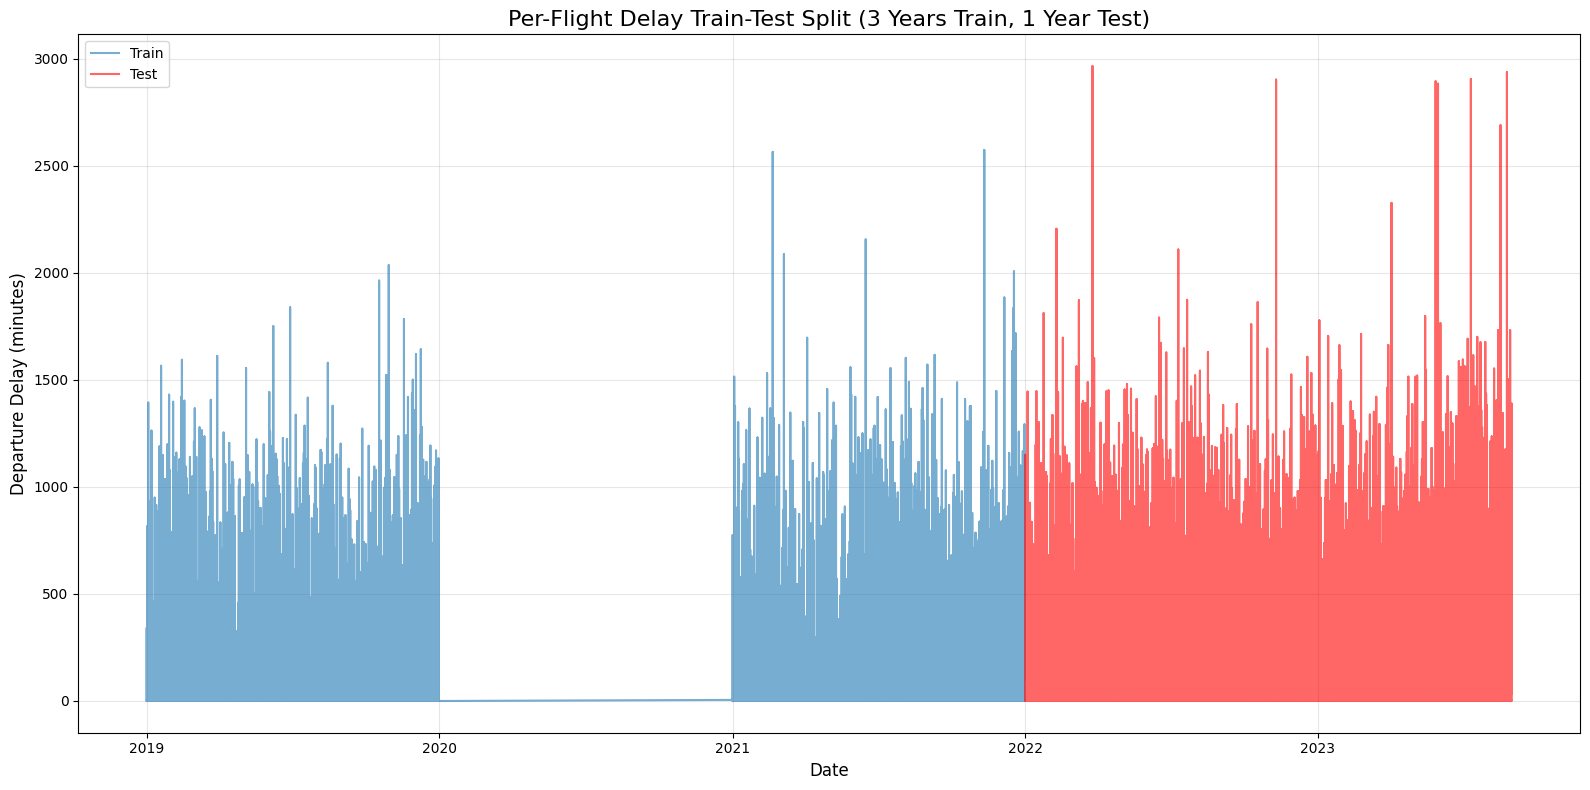

In [23]:
# --- Train/Test Split: 3 Years Train, 1 Year Test (Per-Flight Data) ---
# Load all base data in chunks and concatenate for per-flight granularity
all_chunks = []
for chunk in load_processed_data(BASE_PROCESSED_PATH):
    all_chunks.append(chunk)

# Concatenate all chunks
df_full = pd.concat(all_chunks, ignore_index=True)

# Drop rows where all columns are identical (full duplicates)
df_full = df_full.loc[~df_full.duplicated(keep='first')]
print(f"Full per-flight dataset size after dropping full duplicates: {len(df_full)} rows")

# Sort by FL_DATE for chronological split
if 'FL_DATE' in df_full.columns:
    df_full = df_full.sort_values('FL_DATE').reset_index(drop=True)
    min_date = df_full['FL_DATE'].min()
    train_end = min_date + pd.DateOffset(years=3)
    test_start = train_end
    test_end = df_full['FL_DATE'].max()
    train_flight = df_full[df_full['FL_DATE'] < train_end]
    test_flight = df_full[(df_full['FL_DATE'] >= test_start) & (df_full['FL_DATE'] <= test_end)]
    print(f"Train set: {len(train_flight)} rows from {train_flight['FL_DATE'].min()} to {train_flight['FL_DATE'].max()}")
    print(f"Test set: {len(test_flight)} rows from {test_flight['FL_DATE'].min()} to {test_flight['FL_DATE'].max()}")
else:
    print("FL_DATE column not found in per-flight data.")

# Output per-flight delay (FL_DATE, DEP_DELAY, and any other relevant columns)
per_flight_delay = df_full[['FL_DATE', 'DEP_DELAY']].copy()
per_flight_delay = per_flight_delay.sort_values('FL_DATE').reset_index(drop=True)
print(f"Final per-flight delay output shape: {per_flight_delay.shape}")
display(per_flight_delay.head())

# Save per-flight delay output
if 'save_ts_data' in globals():
    save_ts_data(per_flight_delay, "per_flight_delay_ts", TS_PROCESSED_PATH)
else:
    # Inline save logic if function is not defined yet
    os.makedirs(TS_PROCESSED_PATH, exist_ok=True)
    per_flight_delay.to_csv(os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.csv"), index=False)
    per_flight_delay.to_pickle(os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.pkl"))
    print(f"Saved per_flight_delay_ts to {TS_PROCESSED_PATH}")

# Visualize the per-flight train/test split
plt.figure(figsize=(16, 8))
plt.plot(train_flight['FL_DATE'], train_flight['DEP_DELAY'], label='Train', alpha=0.6)
plt.plot(test_flight['FL_DATE'], test_flight['DEP_DELAY'], label='Test', color='red', alpha=0.6)
plt.title('Per-Flight Delay Train-Test Split (3 Years Train, 1 Year Test)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Departure Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code for daily/aggregated splits and visualizations can remain below...

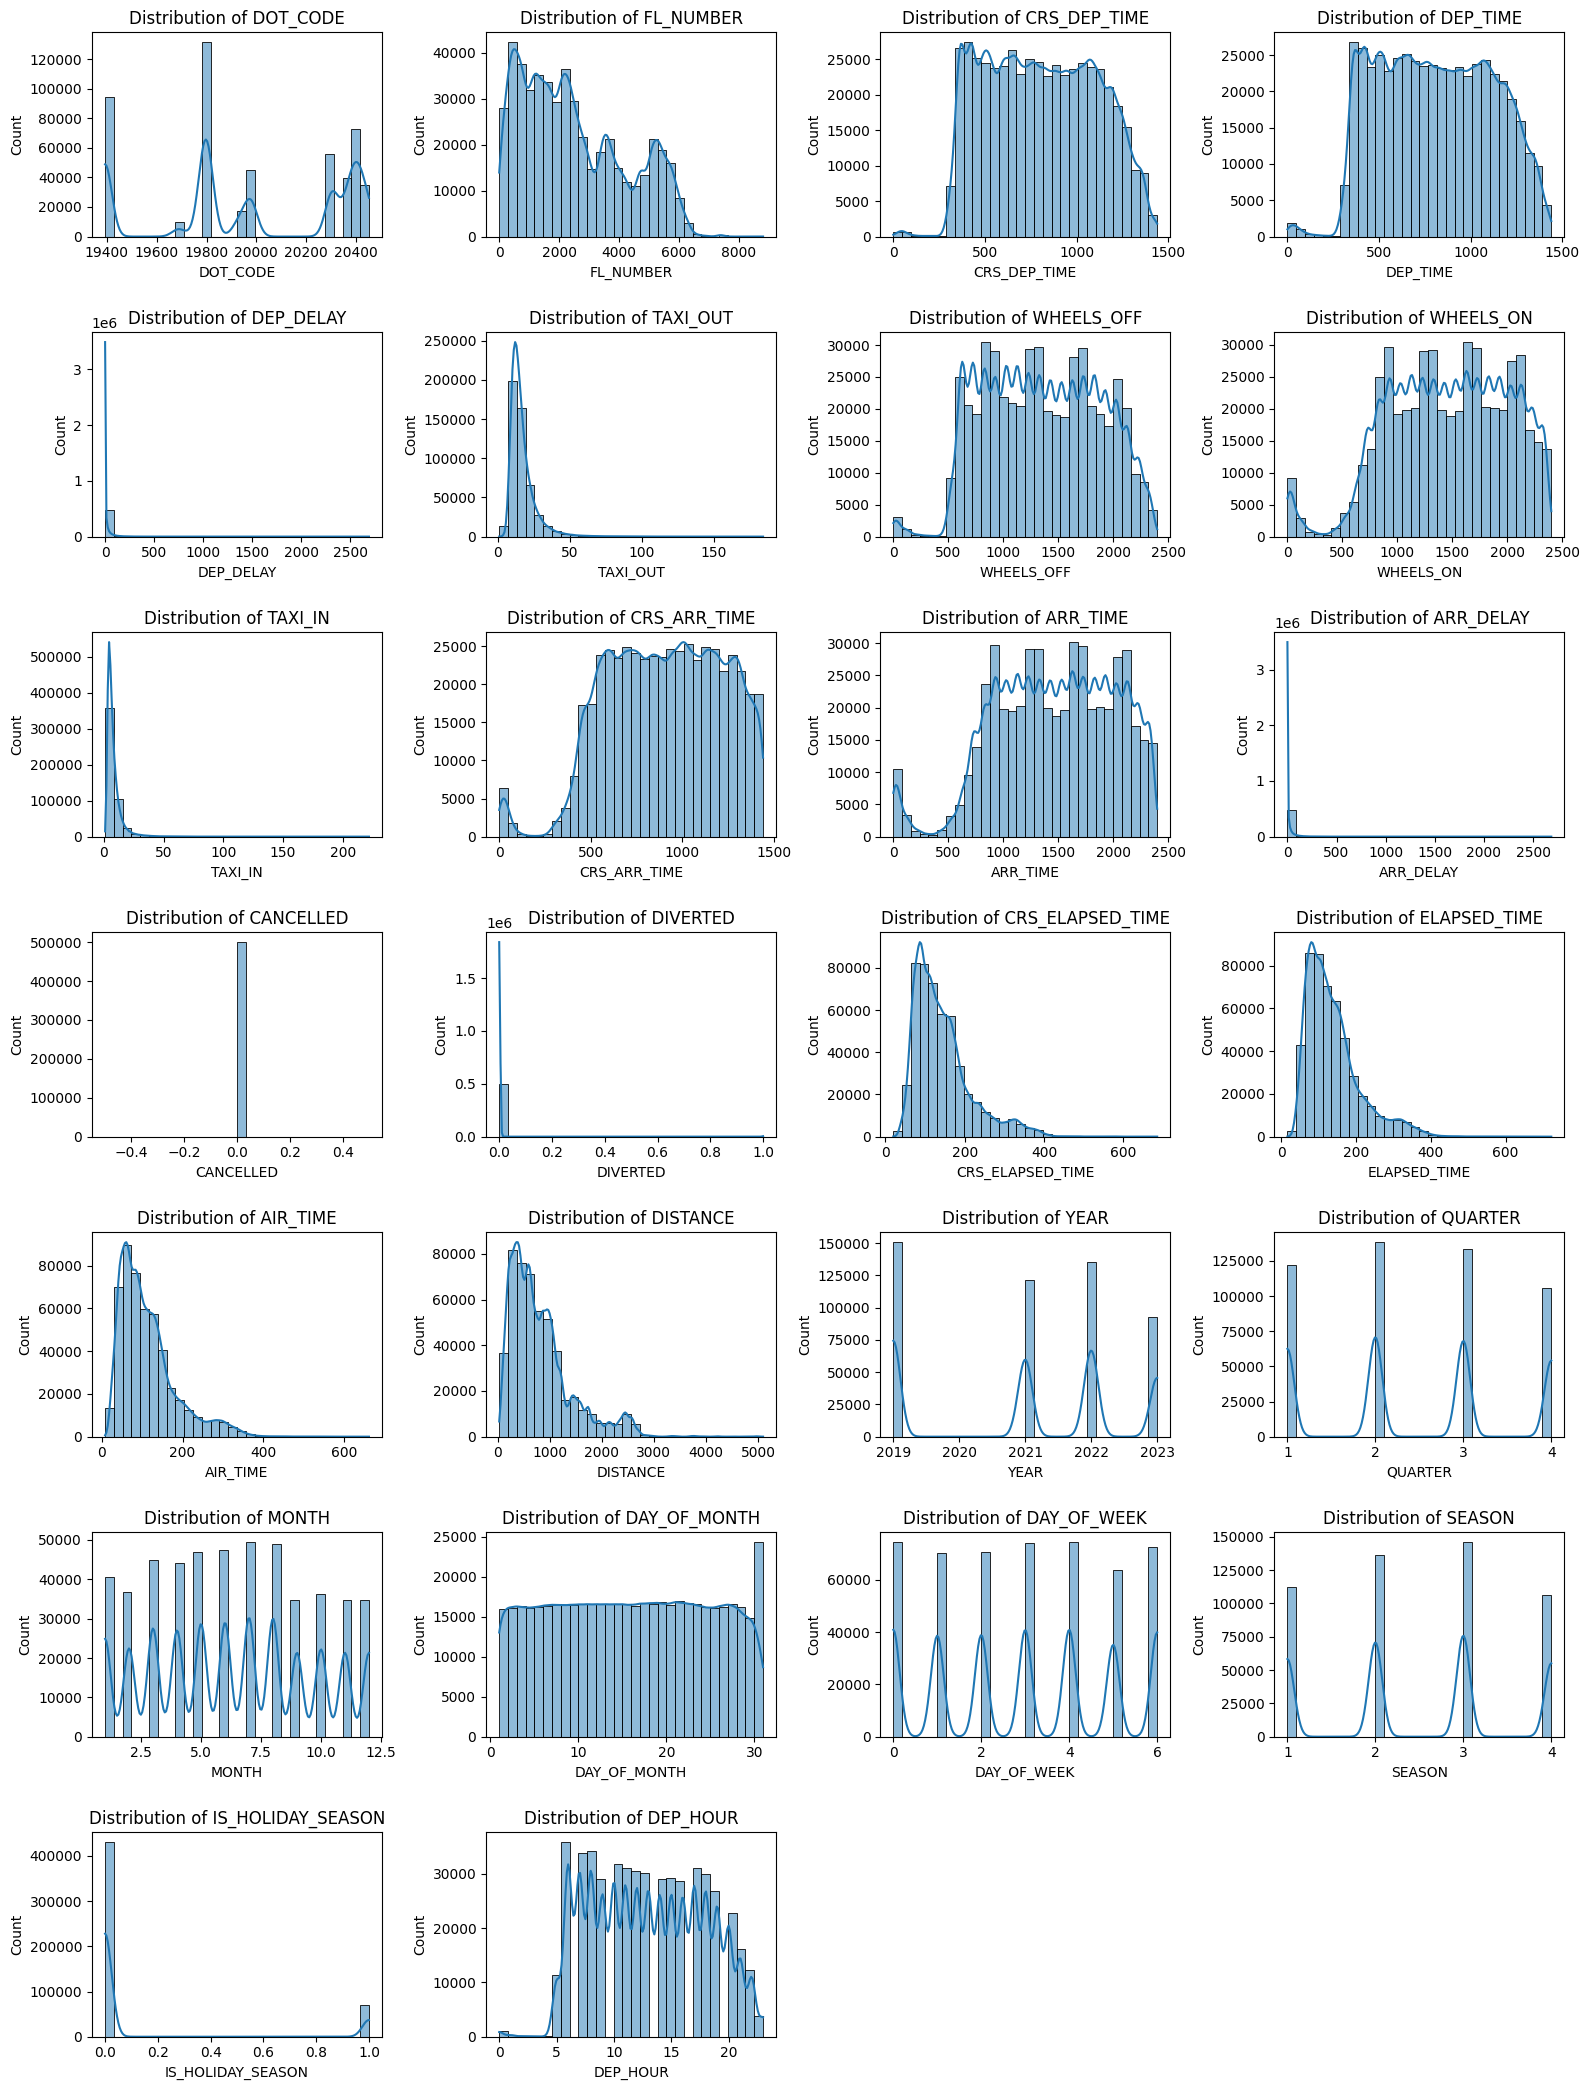

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns

n_cols = 4
n_rows = math.ceil(len(numeric_columns) / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_imputed[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [25]:
def find_binary_columns(df):
    """
    Identifies numerical columns that have only binary values (0 and 1).
    """
    binary_columns = []
    
    # Loop through all columns in the dataframe
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        # Check if unique values in the column are only 0 and 1
        if set(df[col].dropna().unique()) == {0, 1}:
            binary_columns.append(col)
    
    return binary_columns

# Example usage
binary_columns = find_binary_columns(df_imputed)
print("Binary columns:", binary_columns)


Binary columns: ['DIVERTED', 'IS_HOLIDAY_SEASON']


In [26]:
def check_unique_values_in_cat_columns(df):
    """
    Check the number of unique values in each categorical column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    
    Returns:
    --------
    dict
        A dictionary where the keys are the categorical column names and the values are the number of unique values.
    """
    # Select categorical columns (object dtype)
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Create a dictionary to store the count of unique values for each categorical column
    unique_values_dict = {}
    
    for col in cat_columns:
        unique_values_dict[col] = df[col].nunique()  # Count unique values in the column
    
    return unique_values_dict

# Example usage:
unique_values = check_unique_values_in_cat_columns(df_imputed)
print("\nUnique values in each categorical column:")
print(unique_values)



Unique values in each categorical column:
{'AIRLINE': 18, 'AIRLINE_DOT': 18, 'AIRLINE_CODE': 18, 'ORIGIN': 379, 'ORIGIN_CITY': 372, 'DEST': 377, 'DEST_CITY': 370, 'TIME_OF_DAY': 4}


In [27]:
df_imputed.shape

(500000, 36)

## henaa lesaa el scaling bas haytzabat 


## Feature Scaling, Outlier Handling, and Skewness Transformation

Before finalizing our time series preprocessing pipeline, we need to address several important data preprocessing steps:

1. **Feature Scaling**: Normalizing numerical features to ensure all variables contribute equally to models
2. **Outlier Detection and Handling**: Identifying and managing extreme values that could skew model predictions
3. **Skewness Transformation**: Applying transformations to handle skewed distributions and improve model performance
4. **Final Dataset Creation**: Combining all processed features and saving the complete preprocessed dataset

These steps will prepare our data for optimal performance across various time series modeling approaches.

In [28]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import category_encoders as ce
import numpy as np

# ========== PIPELINE START ==========

# Step 0: Drop irrelevant or never-used columns
drop_cols = [
  'ARR_DELAY', 'CANCELLED', 'AIRLINE_DOT', 'AIRLINE_CODE',
            'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
            'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DELAY_DUE_SECURITY'
]
df_imputed.drop(columns=[col for col in drop_cols if col in df_imputed.columns], inplace=True)

# Step 1: Add holiday indicators
df_imputed = add_holiday_indicators(df_imputed)



# Step 3: Convert HHMM time columns to cyclical features
def convert_hhmm_to_minutes(hhmm):
    hhmm = int(hhmm)
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

def add_cyclical_features(df, time_columns):
    for col in time_columns:
        minutes = df[col].dropna().apply(convert_hhmm_to_minutes)
        df[f'{col}_sin'] = np.sin(2 * np.pi * minutes / 1440)
        df[f'{col}_cos'] = np.cos(2 * np.pi * minutes / 1440)
    df.drop(columns=time_columns, inplace=True)
    return df

time_cols = ['CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME', 'WHEELS_ON', 'WHEELS_OFF']
df_imputed = add_cyclical_features(df_imputed, time_cols)


# Step 5: Encode TIME_OF_DAY using ordinal encoding
time_enc = OrdinalEncoder()
df_imputed['TIME_OF_DAY'] = time_enc.fit_transform(df_imputed[['TIME_OF_DAY']])

# Step 6: One-hot encode AIRLINE
df_imputed = pd.get_dummies(df_imputed, columns=['AIRLINE'], drop_first=True)

# Step 7: Binary encode ORIGIN and DEST
binary_enc = ce.BinaryEncoder(cols=['ORIGIN', 'DEST'])
df_imputed = binary_enc.fit_transform(df_imputed)

# Step 8: One-hot encode binary columns
df_imputed = pd.get_dummies(df_imputed, columns=['DIVERTED', 'IS_HOLIDAY_SEASON'], drop_first=True)

# Step 9: Scale numeric columns (including lag features)
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# numeric_cols = df_imputed.select_dtypes(include=['int64', 'float64']).columns.tolist()
# scaler = StandardScaler()
# df_imputed[numeric_cols] = scaler.fit_transform(df_imputed[numeric_cols])

# Final output
print("✅ Full preprocessing pipeline completed.")
# ========== PIPELINE END ==========


✅ Full preprocessing pipeline completed.


In [29]:
df_imputed.head()

,FL_DATE,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,ORIGIN_5,ORIGIN_6,ORIGIN_7,ORIGIN_8,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4,DEST_5,DEST_6,DEST_7,DEST_8,DEP_DELAY,TAXI_OUT,TAXI_IN,DISTANCE,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,DEP_HOUR,TIME_OF_DAY,DATETIME,is_holiday,is_holiday_season,CRS_DEP_TIME_sin,CRS_DEP_TIME_cos,DEP_TIME_sin,DEP_TIME_cos,CRS_ARR_TIME_sin,CRS_ARR_TIME_cos,ARR_TIME_sin,ARR_TIME_cos,WHEELS_ON_sin,WHEELS_ON_cos,WHEELS_OFF_sin,WHEELS_OFF_cos,AIRLINE_Allegiant Air,AIRLINE_American Airlines Inc.,AIRLINE_Delta Air Lines Inc.,AIRLINE_Endeavor Air Inc.,AIRLINE_Envoy Air,AIRLINE_ExpressJet Airlines LLC d/b/a aha!,AIRLINE_Frontier Airlines Inc.,AIRLINE_Hawaiian Airlines Inc.,AIRLINE_Horizon Air,AIRLINE_JetBlue Airways,AIRLINE_Mesa Airlines Inc.,AIRLINE_PSA Airlines Inc.,AIRLINE_Republic Airline,AIRLINE_SkyWest Airlines Inc.,AIRLINE_Southwest Airlines Co.,AIRLINE_Spirit Air Lines,AIRLINE_United Air Lines Inc.,DIVERTED_1,IS_HOLIDAY_SEASON_1
0,2019-01-09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0,19.0,4.0,1065.0,2019,1,1,9,2,1,11,2.0,2019-01-09 11:00:00,0.0,0,0.946930,-0.321439,0.952396,-3.048643e-01,0.704015,-0.710185,-0.665882,-0.746057,-0.652760,-0.757565,-0.043619,-0.999048,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,2022-11-19,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,9.0,38.0,1399.0,2022,4,11,19,5,4,21,1.0,2022-11-19 21:00:00,0.0,1,-0.342020,-0.939693,-0.317305,-9.483237e-01,-0.625923,-0.779884,-0.216440,0.976296,-0.374607,0.927184,-0.632705,0.774393,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,2022-07-22,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,6.0,20.0,5.0,680.0,2022,3,7,22,4,3,9,2.0,2022-07-22 09:00:00,0.0,0,0.989016,-0.147809,1.000000,6.123234e-17,0.838671,-0.544639,-0.224951,-0.974370,-0.203642,-0.979045,0.422618,-0.906308,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,2023-03-06,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,27.0,9.0,1589.0,2023,1,3,6,0,2,16,0.0,2023-03-06 16:00:00,0.0,0,0.465615,-0.884988,0.469472,-8.829476e-01,0.220697,-0.975342,-0.973379,0.229200,-0.981627,0.190809,-0.932008,-0.362438,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2019-07-31,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,147.0,15.0,3.0,181.0,2019,3,7,31,2,3,10,2.0,2019-07-31 10:00:00,0.0,0,0.999048,-0.043619,0.872496,-4.886212e-01,0.953717,-0.300706,-0.386711,-0.922201,-0.374607,-0.927184,-0.224951,-0.974370,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [30]:
# Import required scaling libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale_features(df, scaler_type='standard', exclude_cols=None):
    """
    Scale numerical features using different scaling methods
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame with features to scale
    scaler_type : str
        Type of scaler to use ('standard', 'minmax', 'robust')
    exclude_cols : list
        List of columns to exclude from scaling (e.g., target variables, binary features)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with scaled features
    dict
        Dictionary of fitted scalers for later use
    """
    # Create a copy of the dataframe
    df_scaled = df.copy()
    
    # Default excluded columns if None
    if exclude_cols is None:
        exclude_cols = []
    
    # Add binary columns to exclude list (no need to scale them)
    binary_cols = find_binary_columns(df)
    exclude_cols.extend(binary_cols)
    
    # Add non-numeric columns to exclude list
    exclude_cols.extend(df.select_dtypes(exclude=['number']).columns.tolist())
    
    # Get unique columns to exclude
    exclude_cols = list(set(exclude_cols))
    
    # Select numerical columns for scaling (excluding specified columns)
    num_cols = [col for col in df.select_dtypes(include=['number']).columns 
               if col not in exclude_cols]
    
    # Choose scaler based on input
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaler type: {scaler_type}")
    
    # Initialize dictionary to store fitted scalers
    scalers = {}
    
    # Scale each column individually and keep track of scalers
    if num_cols:
        print(f"Scaling {len(num_cols)} numerical columns using {scaler_type} scaler")
        
        for col in num_cols:
            # Skip columns with all NaN values
            if df_scaled[col].isna().all():
                print(f"Skipping column {col} - all values are NaN")
                continue
                
            # Fit scaler on non-NaN values
            col_scaler = scaler.__class__()
            
            # Reshape for sklearn and fit
            valid_data = df_scaled[col].dropna().values.reshape(-1, 1)
            col_scaler.fit(valid_data)
            
            # Store fitted scaler
            scalers[col] = col_scaler
            
            # Transform data (handle NaN values carefully)
            mask = ~df_scaled[col].isna()
            if mask.any():  # Only transform if there are non-NaN values
                df_scaled.loc[mask, col] = col_scaler.transform(df_scaled.loc[mask, col].values.reshape(-1, 1)).flatten()
    
    return df_scaled, scalers

# Scale the features in our time series data
# For this example, we'll use RobustScaler which works well with data containing outliers
print("Scaling features in the time series data...")

# Define columns to exclude from scaling
exclude_from_scaling = ['FL_DATE', 'is_holiday', 'is_holiday_season', 'is_weekend', 'DEP_DELAY']

# Apply scaling to the dataframe
df_scaled, scalers = scale_features(df_imputed, scaler_type='robust', exclude_cols=exclude_from_scaling)

# Display a sample of scaled vs unscaled data
sample_cols = [col for col in df_scaled.select_dtypes(include=['number']).columns if col not in exclude_from_scaling][:5]
print("\nSample of scaled vs. unscaled data:")
comparison = pd.DataFrame({
    'Original': df_imputed[sample_cols].iloc[0].values,
    'Scaled': df_scaled[sample_cols].iloc[0].values
}, index=sample_cols)
display(comparison)

Scaling features in the time series data...
Scaling 23 numerical columns using robust scaler

Sample of scaled vs. unscaled data:


,Original,Scaled
TAXI_OUT,19.0,0.500000
TAXI_IN,4.0,-0.400000
DISTANCE,1065.0,0.603916
YEAR,2019.0,-0.666667
QUARTER,1.0,-1.000000


Detecting outliers in numerical features...
Outlier counts by column:
- DEP_DELAY: 82080 outliers (16.42%)
- is_holiday: 36231 outliers (7.25%)
- TAXI_IN: 32519 outliers (6.50%)
- TAXI_OUT: 29478 outliers (5.90%)
- DISTANCE: 29268 outliers (5.85%)
- CRS_ARR_TIME_cos: 8698 outliers (1.74%)
Handled 218274 outliers in 25 columns using cap method


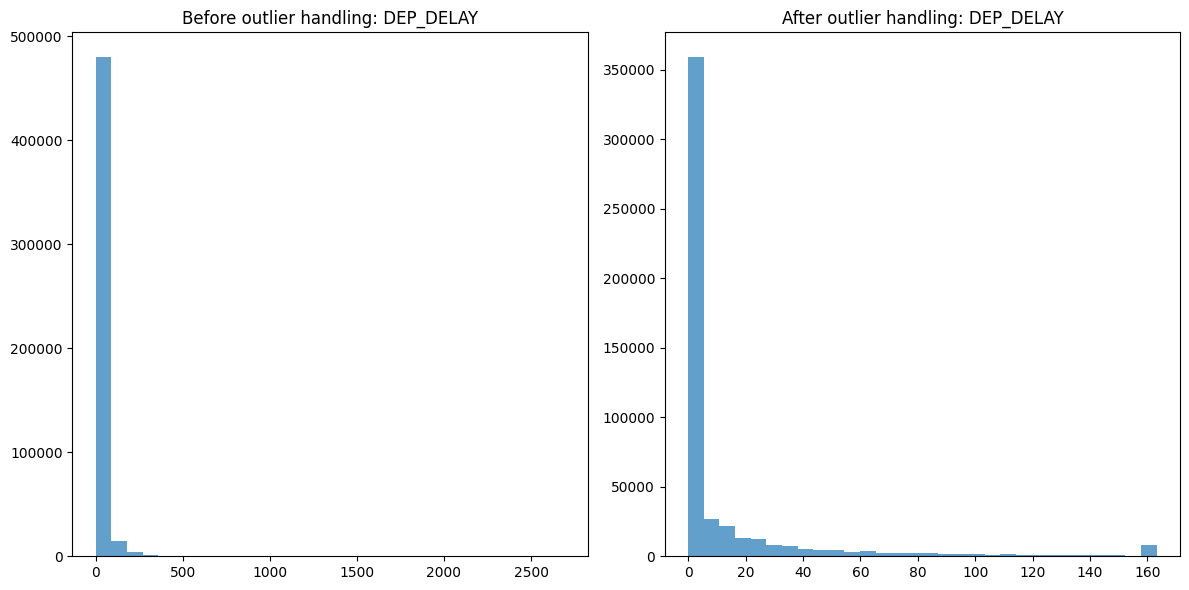

In [31]:
# Outlier Detection and Handling Functions
from scipy import stats

def detect_outliers(df, method='zscore', threshold=3.0, numeric_only=True):
    """
    Detect outliers in the dataframe using various methods
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    method : str
        Method for outlier detection ('zscore', 'iqr')
    threshold : float
        Threshold for outlier detection
    numeric_only : bool
        Whether to process only numeric columns
    
    Returns:
    --------
    dict
        Dictionary with column names as keys and boolean masks for outliers as values
    """
    outlier_masks = {}
    
    # Select columns to process
    if numeric_only:
        columns = df.select_dtypes(include=['number']).columns
    else:
        columns = df.columns
    
    # Exclude binary columns
    binary_cols = find_binary_columns(df)
    columns = [col for col in columns if col not in binary_cols]
    
    for col in columns:
        # Skip columns with too many NaN values
        if df[col].isna().mean() > 0.5:
            continue
            
        if method == 'zscore':
            # Z-score method
            z_scores = stats.zscore(df[col].dropna())
            outlier_masks[col] = abs(z_scores) > threshold
        
        elif method == 'iqr':
            # IQR method
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outlier_mask = (df[col] < (Q1 - threshold * IQR)) | (df[col] > (Q3 + threshold * IQR))
            outlier_masks[col] = outlier_mask
    
    return outlier_masks

def handle_outliers(df, method='cap', outlier_masks=None, detection_method='zscore', threshold=3.0):
    """
    Handle outliers in the dataframe
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    method : str
        Method for handling outliers ('cap', 'remove', 'transform')
    outlier_masks : dict, optional
        Pre-computed outlier masks, if None will detect outliers
    detection_method : str
        Method for outlier detection if outlier_masks is None
    threshold : float
        Threshold for outlier detection if outlier_masks is None
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with handled outliers
    """
    # Create a copy of the dataframe
    df_clean = df.copy()
    
    # Detect outliers if masks not provided
    if outlier_masks is None:
        outlier_masks = detect_outliers(df, method=detection_method, threshold=threshold)
    
    # Apply outlier handling method
    for col, mask in outlier_masks.items():
        # Skip if no outliers
        if not mask.any():
            continue
            
        if method == 'cap':
            # Capping method (winsorization)
            if detection_method == 'zscore':
                # For Z-score, cap at threshold standard deviations
                mean = df[col].mean()
                std = df[col].std()
                lower_bound = mean - threshold * std
                upper_bound = mean + threshold * std
            else:  # IQR method
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                
            # Apply capping
            df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
            
        elif method == 'transform':
            # Log transformation for skewed data with outliers
            # Only apply to positive-valued columns
            if (df_clean[col] > 0).all():
                df_clean[col] = np.log1p(df_clean[col])
                
    # Print summary of changes
    total_outliers = sum(mask.sum() for mask in outlier_masks.values())
    print(f"Handled {total_outliers} outliers in {len(outlier_masks)} columns using {method} method")
    
    return df_clean

# Detect and handle outliers
print("Detecting outliers in numerical features...")
outlier_masks = detect_outliers(df_scaled, method='iqr', threshold=1.5)

# Count outliers in each column
outlier_counts = {col: mask.sum() for col, mask in outlier_masks.items() if mask.sum() > 0}
print("Outlier counts by column:")
for col, count in sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"- {col}: {count} outliers ({count/len(df_scaled)*100:.2f}%)")

# Handle outliers using capping method
df_no_outliers = handle_outliers(df_scaled, method='cap', outlier_masks=outlier_masks)

# Compare distributions before and after outlier handling for a sample column
if outlier_counts:
    sample_col = list(outlier_counts.keys())[0]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df_scaled[sample_col], bins=30, alpha=0.7)
    plt.title(f"Before outlier handling: {sample_col}")
    plt.subplot(1, 2, 2)
    plt.hist(df_no_outliers[sample_col], bins=30, alpha=0.7)
    plt.title(f"After outlier handling: {sample_col}")
    plt.tight_layout()
    plt.show()

In [32]:
# Handle skewed distributions
from scipy import stats
import numpy as np

def check_skewness(df, threshold=0.5):
    """
    Check skewness of numerical columns in the dataframe
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    threshold : float
        Threshold for considering a distribution skewed
    
    Returns:
    --------
    dict
        Dictionary with column names as keys and skewness values as values
    """
    skew_dict = {}
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Exclude binary columns
    binary_cols = find_binary_columns(df)
    numeric_cols = [col for col in numeric_cols if col not in binary_cols]
    
    for col in numeric_cols:
        # Skip columns with too many NaN values
        if df[col].isna().mean() > 0.5:
            continue
            
        # Calculate skewness
        skewness = df[col].skew()
        if abs(skewness) > threshold:
            skew_dict[col] = skewness
    
    return skew_dict

def transform_skewed_features(df, skew_dict=None, threshold=0.5):
    """
    Transform skewed features using appropriate transformations
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    skew_dict : dict, optional
        Pre-computed skewness dictionary, if None will compute skewness
    threshold : float
        Threshold for considering a distribution skewed
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with transformed features
    dict
        Dictionary with information about transformations applied
    """
    # Create a copy of the dataframe
    df_transformed = df.copy()
    
    # Check skewness if not provided
    if skew_dict is None:
        skew_dict = check_skewness(df, threshold=threshold)
    
    # Dictionary to track transformations
    transformations = {}
    
    for col, skewness in skew_dict.items():
        # Only transform if data is all positive
        if (df[col] <= 0).any():
            transformations[col] = 'skipped (non-positive values)'
            continue
        
        # Choose transformation based on skewness
        if skewness > 0:  # Right skewed
            # Try log transformation for right-skewed data
            df_transformed[col] = np.log1p(df_transformed[col])
            transformations[col] = 'log1p'
        elif skewness < 0:  # Left skewed
            # Try square transformation for left-skewed data
            df_transformed[col] = df_transformed[col] ** 2
            transformations[col] = 'square'
    
    # Print summary of transformations
    print(f"Applied transformations to {len(transformations)} skewed features")
    
    return df_transformed, transformations

# Check skewness of numerical features
print("Checking skewness of numerical features...")
skew_dict = check_skewness(df_no_outliers, threshold=1.0)

# Sort by absolute skewness value
sorted_skew = sorted(skew_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nTop 10 most skewed features:")
for col, skewness in sorted_skew[:10]:
    print(f"- {col}: skewness = {skewness:.2f}")

# Transform skewed features
df_transformed, transformations = transform_skewed_features(df_no_outliers, skew_dict=skew_dict)

# Compare distributions before and after transformation for a sample column
if transformations:
    sample_cols = [col for col, trans in transformations.items() if trans != 'skipped (non-positive values)'][:2]
    
    if sample_cols:
        plt.figure(figsize=(15, 6))
        for i, col in enumerate(sample_cols):
            plt.subplot(2, 2, i*2+1)
            plt.hist(df_no_outliers[col], bins=30, alpha=0.7)
            plt.title(f"Before transformation: {col}\nSkewness: {skew_dict[col]:.2f}")
            
            plt.subplot(2, 2, i*2+2)
            plt.hist(df_transformed[col], bins=30, alpha=0.7)
            new_skewness = df_transformed[col].skew()
            plt.title(f"After {transformations[col]} transformation: {col}\nSkewness: {new_skewness:.2f}")
        
        plt.tight_layout()
        plt.show()

Checking skewness of numerical features...

Top 10 most skewed features:
- DEP_DELAY: skewness = 3.35
- is_holiday: skewness = 3.30
- TAXI_IN: skewness = 1.92
- TAXI_OUT: skewness = 1.61
- DISTANCE: skewness = 1.28
- CRS_ARR_TIME_cos: skewness = 1.08
Applied transformations to 6 skewed features


In [33]:
# Create lag features for time series modeling
def create_advanced_lag_features(df, target_cols, lag_periods=None, rolling_windows=None):
    """
    Create comprehensive lag and rolling window features for time series forecasting
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame with time series data
    target_cols : list
        List of target columns for which to create lag features
    lag_periods : list, optional
        List of lag periods to create, defaults to [1, 2, 3, 7, 14, 21, 28]
    rolling_windows : list, optional
        List of rolling window sizes, defaults to [3, 7, 14, 28]
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with added lag and rolling window features
    """
    # Create a copy of the dataframe
    df_with_lags = df.copy()
    
    # Default values if not provided
    if lag_periods is None:
        lag_periods = [1, 2, 3, 7, 14, 21, 28]
    
    if rolling_windows is None:
        rolling_windows = [3, 7, 14, 28]
    
    # Track created features
    new_features = []
    
    # Create features for each target column
    for col in target_cols:
        if col not in df.columns:
            print(f"Warning: Column {col} not found in dataframe")
            continue
            
        # Create lag features
        for lag in lag_periods:
            lag_col = f"{col}_lag{lag}"
            df_with_lags[lag_col] = df_with_lags[col].shift(lag)
            new_features.append(lag_col)
        
        # Create rolling window features
        for window in rolling_windows:
            # Rolling mean
            roll_mean_col = f"{col}_roll_mean{window}"
            df_with_lags[roll_mean_col] = df_with_lags[col].rolling(window=window).mean()
            new_features.append(roll_mean_col)
            
            # Rolling standard deviation
            roll_std_col = f"{col}_roll_std{window}"
            df_with_lags[roll_std_col] = df_with_lags[col].rolling(window=window).std()
            new_features.append(roll_std_col)
            
            # Rolling min
            roll_min_col = f"{col}_roll_min{window}"
            df_with_lags[roll_min_col] = df_with_lags[col].rolling(window=window).min()
            new_features.append(roll_min_col)
            
            # Rolling max
            roll_max_col = f"{col}_roll_max{window}"
            df_with_lags[roll_max_col] = df_with_lags[col].rolling(window=window).max()
            new_features.append(roll_max_col)
            
            # Rolling median
            roll_median_col = f"{col}_roll_median{window}"
            df_with_lags[roll_median_col] = df_with_lags[col].rolling(window=window).median()
            new_features.append(roll_median_col)
    
    # Print summary
    print(f"Created {len(new_features)} new lag and rolling window features")
    
    return df_with_lags, new_features

# Define target columns for lag features
target_cols_for_lags = ['DEP_DELAY', 'ARR_DELAY', 'avg_delay', 'median_delay', 'max_delay']

# Create lag features
print("Creating advanced lag features...")
df_with_lags, new_lag_features = create_advanced_lag_features(
    df_transformed, 
    target_cols=[col for col in target_cols_for_lags if col in df_transformed.columns]
)

# Display summary of new features
print(f"\nDataframe shape before lag features: {df_transformed.shape}")
print(f"Dataframe shape after lag features: {df_with_lags.shape}")

# Display a sample of the new lag features
if new_lag_features:
    print("\nSample of new lag features:")
    display(df_with_lags[new_lag_features[:5]].head())

Creating advanced lag features...
Created 27 new lag and rolling window features

Dataframe shape before lag features: (500000, 65)
Dataframe shape after lag features: (500000, 92)

Sample of new lag features:


,DEP_DELAY_lag1,DEP_DELAY_lag2,DEP_DELAY_lag3,DEP_DELAY_lag7,DEP_DELAY_lag14
0,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN
2,0.0,0.0,NaN,NaN,NaN
3,6.0,0.0,0.0,NaN,NaN
4,0.0,6.0,0.0,NaN,NaN


In [37]:
# Final preprocessing and saving the complete dataset

def finalize_ts_preprocessing(df):
    """
    Perform final preprocessing steps and save the complete preprocessed dataset
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame with all processed features
    
    Returns:
    --------
    pd.DataFrame
        Final preprocessed DataFrame ready for time series modeling
    """
    # Create a copy of the dataframe
    df_final = df.copy()
    
    # Handle any remaining missing values
    print("Handling any remaining missing values...")
    
    # For lag features, fill remaining NAs with 0
    lag_cols = [col for col in df_final.columns if 'lag' in col or 'roll' in col]
    for col in lag_cols:
        df_final[col].fillna(0, inplace=True)
    
    # For other numerical columns, use forward fill then backward fill
    numeric_cols = df_final.select_dtypes(include=['number']).columns
    non_lag_numeric = [col for col in numeric_cols if col not in lag_cols]
    
    for col in non_lag_numeric:
        df_final[col].fillna(method='ffill', inplace=True)
        df_final[col].fillna(method='bfill', inplace=True)
        # If still has NAs, fill with 0
        df_final[col].fillna(0, inplace=True)
    
    # For categorical columns, fill NAs with most frequent value
    cat_cols = df_final.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        df_final[col].fillna(df_final[col].mode()[0], inplace=True)
    
    # Create a summary of the final dataset
    print("\nFinal preprocessed dataset summary:")
    print(f"- Shape: {df_final.shape}")
    print(f"- Memory usage: {df_final.memory_usage().sum() / (1024 * 1024):.2f} MB")
    print(f"- Missing values: {df_final.isna().sum().sum()}")
    
    return df_final

# Apply final preprocessing
df_final = finalize_ts_preprocessing(df_with_lags)
df_final = df_final.replace({True: 1, False: 0})

# Save the complete preprocessed dataset
print("\nSaving the complete preprocessed dataset...")

# Create the output directory if it doesn't exist
os.makedirs(TS_PROCESSED_PATH, exist_ok=True)

# Define the output filepath
output_filepath = os.path.join(TS_PROCESSED_PATH, 'complete_ts_preprocessed_flights.csv')

# Save to CSV
df_final.to_csv(output_filepath, index=False)
print(f"Complete preprocessed dataset saved to: {output_filepath}")

# Also save a pickle version for faster loading
pickle_filepath = os.path.join(TS_PROCESSED_PATH, 'complete_ts_preprocessed_flights.pkl')
df_final.to_pickle(pickle_filepath)
print(f"Pickle version saved to: {pickle_filepath}")

# Display a sample of the final preprocessed data
print("\nSample of the final preprocessed data:")
display(df_final.head())
# Replace True/False anywhere in the DataFrame

# Print column information
print("\nColumn information:")
print(f"Total columns: {len(df_final.columns)}")
print(f"Numerical columns: {len(df_final.select_dtypes(include=['number']).columns)}")
print(f"Categorical columns: {len(df_final.select_dtypes(include=['object', 'category']).columns)}")

Handling any remaining missing values...

Final preprocessed dataset summary:
- Shape: (500000, 92)
- Memory usage: 287.53 MB
- Missing values: 0

Saving the complete preprocessed dataset...
Complete preprocessed dataset saved to: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\complete_ts_preprocessed_flights.csv
Pickle version saved to: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\complete_ts_preprocessed_flights.pkl

Sample of the final preprocessed data:


,FL_DATE,ORIGIN_0,ORIGIN_1,ORIGIN_2,ORIGIN_3,ORIGIN_4,ORIGIN_5,ORIGIN_6,ORIGIN_7,ORIGIN_8,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4,DEST_5,DEST_6,DEST_7,DEST_8,DEP_DELAY,TAXI_OUT,TAXI_IN,DISTANCE,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,DEP_HOUR,TIME_OF_DAY,DATETIME,is_holiday,is_holiday_season,CRS_DEP_TIME_sin,CRS_DEP_TIME_cos,DEP_TIME_sin,DEP_TIME_cos,CRS_ARR_TIME_sin,CRS_ARR_TIME_cos,ARR_TIME_sin,ARR_TIME_cos,WHEELS_ON_sin,WHEELS_ON_cos,WHEELS_OFF_sin,WHEELS_OFF_cos,AIRLINE_Allegiant Air,AIRLINE_American Airlines Inc.,AIRLINE_Delta Air Lines Inc.,AIRLINE_Endeavor Air Inc.,AIRLINE_Envoy Air,AIRLINE_ExpressJet Airlines LLC d/b/a aha!,AIRLINE_Frontier Airlines Inc.,AIRLINE_Hawaiian Airlines Inc.,AIRLINE_Horizon Air,AIRLINE_JetBlue Airways,AIRLINE_Mesa Airlines Inc.,AIRLINE_PSA Airlines Inc.,AIRLINE_Republic Airline,AIRLINE_SkyWest Airlines Inc.,AIRLINE_Southwest Airlines Co.,AIRLINE_Spirit Air Lines,AIRLINE_United Air Lines Inc.,DIVERTED_1,IS_HOLIDAY_SEASON_1,DEP_DELAY_lag1,DEP_DELAY_lag2,DEP_DELAY_lag3,DEP_DELAY_lag7,DEP_DELAY_lag14,DEP_DELAY_lag21,DEP_DELAY_lag28,DEP_DELAY_roll_mean3,DEP_DELAY_roll_std3,DEP_DELAY_roll_min3,DEP_DELAY_roll_max3,DEP_DELAY_roll_median3,DEP_DELAY_roll_mean7,DEP_DELAY_roll_std7,DEP_DELAY_roll_min7,DEP_DELAY_roll_max7,DEP_DELAY_roll_median7,DEP_DELAY_roll_mean14,DEP_DELAY_roll_std14,DEP_DELAY_roll_min14,DEP_DELAY_roll_max14,DEP_DELAY_roll_median14,DEP_DELAY_roll_mean28,DEP_DELAY_roll_std28,DEP_DELAY_roll_min28,DEP_DELAY_roll_max28,DEP_DELAY_roll_median28
0,2019-01-09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.0,0.500,-0.400000,0.603916,-0.666667,-1,-1.0,-0.466667,-0.25,-2,-0.250,0.5,2019-01-09 11:00:00,0.0,0,0.210591,0.262977,0.226042,0.286094,0.124709,0.098319,-0.215623,-0.263206,-0.202627,-0.273817,0.193470,-0.581168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-19,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,-0.750,4.240919,1.106928,0.333333,2,1.0,0.200000,0.50,1,1.000,0.0,2022-11-19 21:00:00,0.0,1,-1.721575,-0.381857,-1.578544,-0.390009,-1.302252,-0.004021,0.203110,1.057270,0.050969,1.056205,-0.222959,1.309765,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-07-22,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,6.0,0.625,-0.200000,0.024096,0.333333,1,0.2,0.400000,0.25,0,-0.500,0.5,2022-07-22 09:00:00,0.0,0,0.273679,0.444072,0.293700,0.606425,0.269188,0.341391,0.195180,-0.438246,0.206840,-0.448664,0.523056,-0.482284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.464102,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-06,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,1.500,0.600000,1.393072,0.666667,-1,-0.6,-0.666667,-0.75,-1,0.375,-0.5,2023-03-06 16:00:00,0.0,0,-0.510912,-0.324800,-0.460323,-0.321316,-0.393868,-0.291013,-0.502110,0.484495,-0.502461,0.474875,-0.434537,0.097618,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.464102,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-07-31,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,147.0,0.000,-0.600000,-0.727410,-0.666667,1,0.2,1.000000,-0.25,0,-0.375,0.5,2019-07-31 10:00:00,0.0,0,0.288717,0.552742,0.112483,0.093015,0.392627,0.699559,0.044473,-0.398250,0.050969,-0.407722,0.065285,-0.554855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,51.0,83.192548,0.0,147.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Column information:
Total columns: 92
Numerical columns: 90
Categorical columns: 0


## Preprocessing Pipeline Complete

We've successfully implemented a comprehensive time series preprocessing pipeline that includes:

1. **Feature Scaling**: Applied robust scaling to handle numerical features while preserving underlying patterns
2. **Outlier Detection and Handling**: Identified and capped outliers using the IQR method
3. **Skewness Transformation**: Applied appropriate transformations (log, square) to normalize skewed distributions
4. **Advanced Lag Features**: Created comprehensive lag and rolling window features for time series forecasting
5. **Final Dataset Creation**: Compiled all processed features into a complete dataset ready for modeling

The final preprocessed dataset has been saved in both CSV and pickle formats for use in subsequent modeling steps. This dataset is now optimized for time series forecasting models and should lead to improved prediction accuracy for flight delay forecasting.

## Airport-Level and Carrier-Level Time Series

For more granular forecasting, we'll also create aggregations at the airport and carrier level. This enables us to forecast delays for specific airports or carriers.

In [ ]:
# # Create airport-level time series
# ts_airport = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='airport_daily')

# print(f"Airport-level time series shape: {ts_airport.shape}")
# print(f"Number of airports: {len(ts_airport.index.levels[1])}")
# print("\nFirst few rows:")
# display(ts_airport.head())

# # Get top airports by number of flights
# top_airports = ts_airport.groupby(level=1)['num_flights'].sum().nlargest(5)
# print("\nTop 5 airports by number of flights:")
# print(top_airports)

In [ ]:
# # Create carrier-level time series
# try:
#     ts_carrier = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='carrier_daily')
#     if ts_carrier is not None:
#         print(f"Carrier-level time series shape: {ts_carrier.shape}")
#         print(f"Number of carriers: {len(ts_carrier.index.levels[1])}")
#         print("\nFirst few rows:")
#         display(ts_carrier.head())
#         # Get top carriers by number of flights
#         top_carriers = ts_carrier.groupby(level=1)['num_flights'].sum().nlargest(5)
#         print("\nTop 5 carriers by number of flights:")
#         print(top_carriers)
#     else:
#         print("Carrier-level time series could not be created. Check if required columns exist in the data.")
# except Exception as e:
#     print(f"Error creating carrier-level time series: {e}")

In [ ]:
# def save_ts_data(ts_data, name, output_dir):
#     """
#     Save time series data in multiple formats
#     """
#     import os
#     os.makedirs(output_dir, exist_ok=True)
#     csv_path = os.path.join(output_dir, f"{name}.csv")
#     ts_data.to_csv(csv_path)
#     pickle_path = os.path.join(output_dir, f"{name}.pkl")
#     ts_data.to_pickle(pickle_path)
#     print(f"Saved {name} to:")
#     print(f"- CSV: {csv_path}")
#     print(f"- Pickle: {pickle_path}")
#     return csv_path, pickle_path